In [34]:
import sys
sys.path.append('/Users/rylanspence/Desktop/Git/DC/pyDCI/src')

In [1]:
# System imports
from pathlib import Path
import importlib

# Math imports
import pandas as pd
import numpy as np
import random
from scipy.stats import uniform
from pandas import DataFrame

# Plotting imports
import seaborn as sns
from typing import List, Dict, Any, Optional, Union, Tuple, Callable, Sequence, Iterable
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import FancyBboxPatch
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
from matplotlib import ticker

import matplotlib.axes._axes as axes
from enum import Enum, auto
import matplotlib.pyplot as Axes


# PyDCI imports
from pydci.utils import get_l2_errs, set_seed
from pydci.utils import get_search_combinations
from pydci.utils import closest_factors
from pydci.utils import get_df
import pydci.consistent_bayes.OnlineSequential as os
import pydci.consistent_bayes.OfflineSequentialSearch as oss
from pydci import OfflineSequential, OfflineSequentialSearch
from pydci.examples import seirs
from pydci.examples import adcirc as ad
from pydci import PCAMUDProblem, OfflineSequential
from pydci.plotting import DEF_RC_PARAMS, plot_interval_lines, add_plot_settings, make_legend


# Pl
DEF_RC_PARAMS = {
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "savefig.facecolor": "white",
}

plt.rcParams.update(DEF_RC_PARAMS)

sns.set_style('white')
sns.set_palette('bright')

In [2]:
# logging.disable(logging.CRITICAL)

In [3]:
# Adcirc specific
def get_wind_data():
    data_dir = '../data/si-inlet-full-ds.pickle'
    path_local = Path(data_dir) # Path.cwd() / "PRJ-3492_archive/PRJ-3492/si-inlet-full-ds.pickle"
    full_data= ad.load_full_ds(path_local)
    wind_data = pd.read_csv('../data/adcirc-si-wind.csv')
    wind_data['time'] = pd.to_datetime(wind_data['time'])
    return full_data, wind_data

def split_range(mask, n_splits):
    return [range(x[0], x[-1]) for x in np.array_split(mask, n_splits)]

def build_df(full_ds, std_deviation, random_seed):
    ret = ad.build_ds(
        data=full_ds, seed=random_seed, std_dev=std_deviation, outpath="../data/pydci_si_example"
    )
    data = ret["data"]
    data['ts'] = pd.to_datetime(data['ts'])
    samples = ret["samples"]
    lambdas = get_df(data, "lam_true", size=2)[0]
    return data, samples, lambdas

def get_mask_intervals(data_df, time, n_splits=4):
    mask = data_df.index[(data_df["ts"] > time[0]) & (data_df["ts"] < time[1])].values
    mask = range(min(mask), max(mask))
    intervals = split_range(mask, n_splits)
    return mask, intervals


def add_banner(ax: Axes, wind_speeds: List[float]) -> None:
    """
    Add a banner with wind speed information to the plot.

    Parameters
    ----------
    ax : Axes
        The matplotlib axes to add the banner to.
    wind_speeds : List[float]
        A list of wind speeds to be displayed on the banner.

    Returns
    -------
    None
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    fontdict = {'fontsize': 24, 'fontweight': 'bold'}

    ax.text(xlim[0], ylim[1] - 0.1, f"AVG:", fontdict=fontdict)
    offsets = [0.13, 0.63, 1.13, 1.63]
    for offset, wind_speed in zip(offsets, wind_speeds):
        ax.text(xlim[0] + offset, ylim[1] - 0.1, f"Wind Speed: {wind_speed} m/s", fontdict=fontdict)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="lightcyan")
    ax.add_patch(FancyBboxPatch((xlim[0], ylim[1] - 0.1), xlim[1] - xlim[0] + 0.2, 0.6,
                                 boxstyle="round,pad=0.05", edgecolor="dimgrey", facecolor="gainsboro"))


def plot_state_with_banner_sub(
    data: pd.DataFrame, wind_speeds: Optional[List[float]] = None,
    samples: Optional[pd.DataFrame] = None, mask: Optional[np.ndarray] = None,
    plot_intervals: Optional[List[pd.Timestamp]] = None, ax: Optional[plt.Axes] = None,
    legend_coords: Optional[Tuple[float, float]] = None, **wind_plot_settings: Any) -> plt.Axes:
    """
    Plot ADCIRC state with wind banner. Settings used in paper [ref]

    Parameters:
    -----------
    data: pd.DataFrame
        The data to plot.
    wind_speeds: Optional[List[float]]
        A list of wind speeds to plot.
    samples: Optional[pd.DataFrame]
        The samples to plot.
    mask: Optional[np.ndarray]
        The mask to apply to the data.
    plot_intervals: Optional[List[pd.Timestamp]]
        The intervals to plot.
    ax: Optional[plt.Axes]
        The axes to plot on.
    legend_coords: Optional[Tuple[float, float]]
        The coordinates of the legend.
    **wind_plot_settings: Any
        Additional settings for the wind plot.

    Returns:
    --------
    ax: plt.Axes
        The axes object.
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    mask = data.index.values if mask is None else mask
    
    ax = plot_interval_lines(data, plot_intervals, ax=ax)
    
    if samples is not None:
        cols = [
            c
            for c in samples.columns
            if c.startswith("q_lam_") and int(c.split("_")[-1]) in mask
        ]
        num_plot = 100
        for idx, i in enumerate(
            np.random.choice(range(len(samples)), num_plot, replace=False)
        ):
            to_plot = pd.DataFrame(
                samples.iloc[[i]][cols].values.T, columns=[f"q_lam_s={i}"]
            )
            to_plot["ts"] = data.iloc[mask]["ts"].values
            label = None if idx != num_plot - 1 else "Predicted"
            sns.lineplot(
                to_plot,
                x="ts",
                y=f"q_lam_s={i}",
                ax=ax,
                color="red",
                alpha=0.1,
                linewidth=2,
                label=label,
                zorder=2,
            )
            
        
    sns.scatterplot(
        data.iloc[mask],
        x="ts",
        y="q_lam_obs_0",
        marker=".",
        s=100,
        label="Observed",
        ax=ax,
        zorder=3,
    )

    sns.lineplot(
        data.iloc[mask], x="ts", y="q_lam_true_0", label="True",color='black', linestyle="solid", linewidth="4",zorder=4,ax=ax)
    
    ax.set_ylim(wind_plot_settings['y_lim'])
    add_banner(ax, wind_speeds=wind_speeds)
    wind_plot_settings.update({'ax': ax})
    add_plot_settings(**wind_plot_settings)

    final_colors = ["red", "black", "blue"]
    final_labels = ["Predicted", "True Signal", "Observations"]
    make_legend(ax, final_labels, final_colors, legend_coords=legend_coords)

    return ax


def generate_wind_data(
    get_wind_data: Callable[[], Tuple[Any, pd.DataFrame]],
    build_df: Callable[[Any, float, int], Tuple[pd.DataFrame, pd.DataFrame, float]],
    get_mask_intervals: Callable[[pd.DataFrame, List[str], int], Tuple[np.ndarray, List[pd.Timestamp]]]
) -> Tuple[List[Tuple[str, Dict[str, str], List[pd.Timestamp]]], List[float]]:
    """
    Analyze wind data within a specified time interval.

    Parameters
    ----------
    get_wind_data : Callable
        A function that returns the full dataset and wind data when called.
    build_df : Callable
        A function to build dataframes with parameters, expected to return a tuple 
        of dataframes and a reference value.
    get_mask_intervals : Callable
        A function to get mask intervals from the dataframe within specified times.

    Returns
    -------
    Tuple[List[Tuple[str, Dict[str, str], List[pd.Timestamp]]], List[float]]
        The first element of the tuple is a list of plotting metadata.
        The second element is a list of mean wind speeds in 12-hour intervals.
    """
    
    # Constants
    TIME_INTERVAL = ["2018-01-07 00:00:00", "2018-01-09 00:00:00"]
    N_SPLITS = 4

    # Load datasets
    full_ds, wind_data = get_wind_data()

    # Build dataframes with parameters
    data_df, samples_df, lam_ref = build_df(full_ds, std_deviation=0.1, random_seed=21)

    # Get mask intervals using constants
    t3_mask, intervals = get_mask_intervals(data_df, TIME_INTERVAL, n_splits=N_SPLITS)

    # Define plotting metadata in a list of tuples
    plot_intervals = [(f"{N_SPLITS} Intervals", {"color": "orange", "linestyle": "-"}, intervals)]

    # Filter wind data for the specified time range and calculate the mean wind speed in chunks
    wind_data_filtered = wind_data.set_index("time").loc[TIME_INTERVAL[0]:TIME_INTERVAL[1]]
    wind_speeds = wind_data_filtered["wind_speed"]
    # Compute mean wind speeds in 12-hour chunks, using groupby to avoid manual iteration
    wind_means = wind_speeds.groupby(wind_speeds.index.floor('12H')).mean().round(1).tolist()


    return t3_mask, data_df, samples_df, lam_ref, plot_intervals, wind_means


def plot_state_with_banner(
    data_df: DataFrame, 
    samples_df: DataFrame, 
    t3_mask: DataFrame, 
    wind_speeds: DataFrame,
    plot_intervals: bool,
     wind_plot_settings: Dict[str, Any],
    legend_coords: Tuple[float, float] = (0.95, 0.25),
    ) -> None:
    """
    Set the style and palette of the plot, create a subplot, and plot the state data.

    Parameters
    ----------
    data_df : DataFrame
        The main data DataFrame.
    samples_df : DataFrame
        The samples DataFrame.
    t3_mask : DataFrame
        The mask DataFrame for filtering data.
    wind_speeds : DataFrame
        DataFrame containing wind speed data.
    plot_intervals : bool
        A flag to indicate whether to plot intervals.
    legend_coords : Tuple[float, float], optional
        The coordinates for placing the legend on the plot. Default is (0.95, 0.25).

    Returns
    -------
    None
        This function does not return anything. It shows a plot.

    """
    sns.set_style('white')
    sns.set_palette('bright')
    fig, axs = plt.subplots(1, 1, figsize=(18, 10))
    
    # Assuming plot_state is a predefined function elsewhere in the codebase
    wind_plot_settings.update({'ax': axs})
    ax = plot_state_with_banner_sub(data_df, samples=samples_df, mask=t3_mask, wind_speeds=wind_speeds,
                    plot_intervals=plot_intervals,legend_coords=legend_coords, **wind_plot_settings)
    
    plt.tight_layout()
    plt.show()



In [18]:
# Added to plotting
def make_legend(ax: Axes, final_labels: List[str], final_colors: List[str], legend_coords: Optional[Tuple[float, float]] = None) -> Legend:
    """
    Create and style a legend for the given axes.

    Parameters
    ----------
    ax : Axes
        The axes object to which the legend will be added.
    final_labels : List[str]
        The labels for the legend entries.
    final_colors : List[str]
        The colors for the legend entries.
    legend_coords : Optional[Tuple[float, float]]
        The coordinates for placing the legend. If None, 'lower left' will be used.

    Returns
    -------
    None
    """
    
    # Create the legend
    legend = ax.legend(
        bbox_to_anchor=legend_coords if legend_coords is not None else "lower left",
        labels=final_labels,
        handlelength=1.5,
        frameon=False
    )
    
    # Set properties of the legend label lines and texts
    for idx, (line, text) in enumerate(zip(legend.get_lines(), legend.get_texts())):
        line.set_color(final_colors[idx])
        line.set_alpha(1.0)

        # Set specific properties for the third legend entry
        if idx == 2:
            line.set_marker('.')
            line.set_markersize(30)
            line.set_linewidth(0.01)
        else:
            line.set_linewidth(10)
        
        text.set_alpha(1.0)
        text.set_fontsize(24)
        text.set_color("black")
        text.set_weight('bold')


# Added to plotting.py
def add_plot_settings(
    ax: Axes, 
    title: str, 
    label_pads: List[int],
    x_lim: List[int],
    y_lim: List[int], 
    label_sizes: List[int],
    loc: List[float], 
    axis_labels: List[str], 
     tick_label_size: int,
    title_pad: int, 
    title_font_size: int
) -> None:
    """
    Configures the plot settings for the provided Axes object, including the title,
    tick locator intervals, label padding, axis labels, and tick label size.

    Parameters
    ----------
    ax : Axes
        The Axes object to apply settings to.
    title : str
        The title of the plot.
    x_lim : List[int]
        A list containing the x-axis limits.
    y_lim : List[int] 
        A list containing the y-axis limits.
    label_pads : List[int]
        A list containing the padding for the x-axis and y-axis labels.
    label_sizes : List[int]
        A list containing the font sizes for the x-axis and y-axis labels.
    loc : List[float]
        A list containing the locator interval for the x-axis and y-axis.
    axis_labels : List[str]
        A list containing the labels for the x-axis and y-axis.
    tick_label_size : int
        The font size for the tick labels.
    title_pad : int
        The padding for the plot title.
    title_font_size : int

    Returns
    -------
    None

    """
        
    ax.set_xlim(*x_lim) if x_lim is not None else None
    ax.set_ylim(*y_lim) if y_lim is not None else None

        
    ax.xaxis.set_major_locator(mticker.MultipleLocator(loc[0])) if loc[0] is not None else None
    ax.yaxis.set_major_locator(mticker.MultipleLocator(loc[1])) if loc[1] is not None else None
    
    ax.tick_params(axis='x', labelsize=tick_label_size)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    ax.xaxis.labelpad = label_pads[0]
    ax.yaxis.labelpad = label_pads[1]
    
    ax.set_xlabel(axis_labels[0], fontsize=label_sizes[0], fontweight='bold')
    ax.set_ylabel(axis_labels[1], fontsize=label_sizes[1], fontweight='bold')
    
    if title is not None:
        ax.set_title(title, fontsize=title_font_size, fontweight='bold', pad=title_pad)


# Added to plotting.py
def plot_interval_lines(data: pd.DataFrame, 
                        plot_intervals: Optional[List[Tuple[str, Dict[str, Any], List[Tuple[int, int]]]]] = None, 
                        ax: Optional[plt.Axes] = None) -> plt.Axes:
    """
    Plots vertical lines on an Axes at the intervals specified in the data.

    Parameters
    ----------
    data : pandas.DataFrame
        A pandas DataFrame containing the data to be plotted. Must contain a time column.
    plot_intervals : Optional[List[Tuple[str, Dict[str, Any], List[Tuple[int, int]]]]], optional
        A list of tuples where each tuple contains a label string, a dictionary of arguments to 
        pass to axvline, and a list of tuples, each of which represents an interval with start and 
        end indexes in the time column. By default, it is None, which means no intervals are plotted.
    ax : Optional[matplotlib.pyplot.Axes], optional
        The matplotlib Axes object where the lines will be plotted. If None, it will be created.

    Returns
    -------
    matplotlib.pyplot.Axes
        The matplotlib Axes object with the interval lines plotted.

    """
    if ax is None:
        ax = plt.gca()

    time_col = 'ts' if 'ts' in data.columns else 'time'
    plot_intervals = plot_intervals or []

    for _, args, intervals in plot_intervals:
        for interval in intervals:
            args["label"] = None
            ax.axvline(data[time_col][interval[0]], linewidth=1, c="darkgoldenrod", zorder=1, **args)
        args["label"] = "Intervals"
        ax.axvline(data[time_col][intervals[-1][-1]], linewidth=1, c="darkgoldenrod", zorder=1, **args)
    
    return ax

In [4]:
t3_mask, data_df, samples_df, lam_ref, plot_intervals, wind_means = generate_wind_data(get_wind_data, build_df, get_mask_intervals)

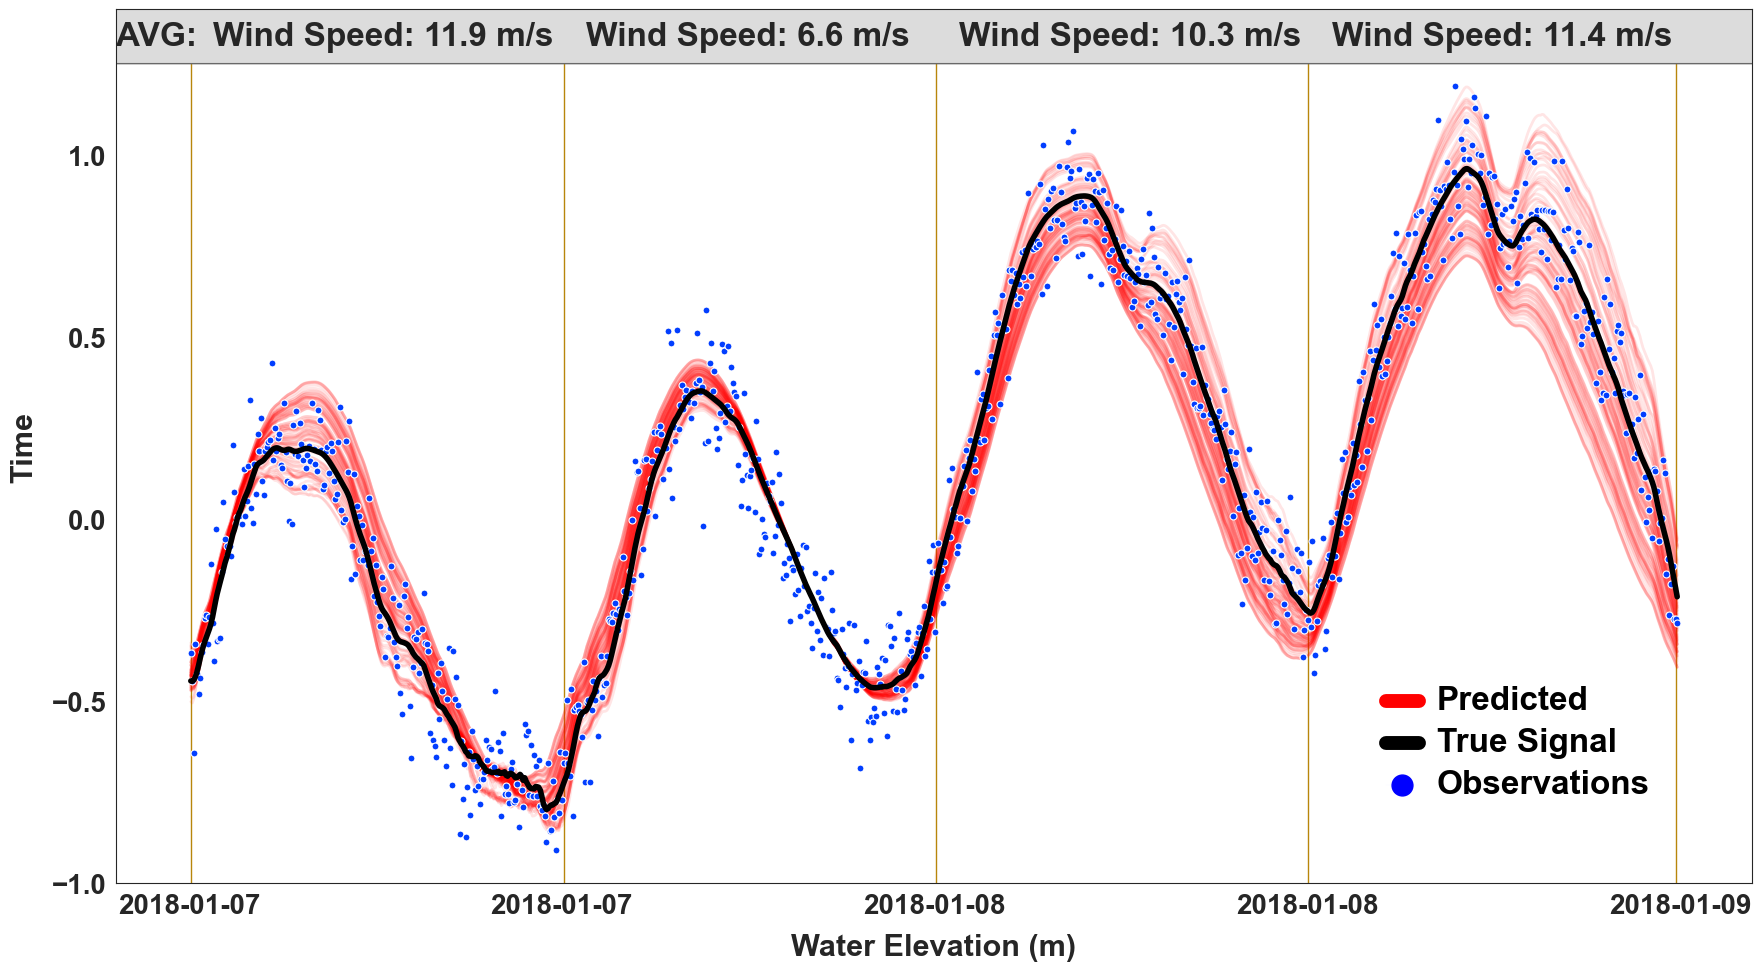

In [8]:
wind_plot_settings = {
    'ax':None,
    'title':None,
    'x_lim':None,
    'y_lim':[-1.0,1.4],
    'label_pads': [10,10],
    'label_sizes': [22,22],
    'loc': [0.5, 0.5],
    'axis_labels': ["Water Elevation (m)", "Time"],
    'tick_label_size': 20,
    'title_pad': 10,
    'title_font_size': 32,
}
plot_state_with_banner(data_df, samples_df, t3_mask, wind_means, plot_intervals, wind_plot_settings, legend_coords=(0.95, 0.25))

____

___

In [41]:
std_dev=0.1,


pca = [None, None]
pca[0] = PCAMUDProblem(samples_df, data_df, std_dev)
pca[0].set_weights([])
pca[0].solve(pca_components=[0], pca_mask=t3_mask)

pca[1] = PCAMUDProblem(samples_df, data_df, std_dev)
pca[1].set_weights([])
pca[1].solve(pca_components=[0, 1], pca_mask=t3_mask)

pca[0].result,pca[1].result

(        e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
 0  1.208838  2.920785    1.0  0.164329    True  None   0.088594   0.002541   
 
    MUD_idx pca_components           pca_mask  
 0      155            [0]  range(2774, 3732)  ,
         e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
 0  1.129287  4.347987    1.0  0.141283    True  None   0.069212   0.002584   
 
    MUD_idx pca_components           pca_mask  
 0      439         [0, 1]  range(2774, 3732)  )

In [42]:
# TODO: Add skip option if e_r value outside of threshold on iterative solves.
n_splits = 4
pca_it = OfflineSequential(samples_df, data_df, std_dev)
pca_it.solve(
    pca_mask=t3_mask, pca_splits=n_splits, pca_components=[[0]], exp_thresh=1e10
)
pd.concat(pca_it.results)

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i,I
0,1.103141,1.469817,1.000000,0.563126,True,None,0.080046,0.002479,403,[0],"range(2774, 3014)",1,4
0,0.810056,1.174189,0.563126,0.476954,True,None,0.063742,0.002642,377,[0],"range(3014, 3254)",2,4
0,1.066731,0.561245,0.476954,0.271543,True,None,0.067741,0.002538,905,[0],"range(3254, 3493)",3,4
0,0.884539,1.585180,0.271543,0.153307,True,None,0.063742,0.002642,377,[0],"range(3493, 3732)",4,4


In [43]:
pca_it.states.iteration.unique()

array([1, 2, 3, 4])

In [44]:
pca_it.state.columns

Index(['weight', 'pi_in', 'pi_pr', 'pi_obs', 'ratio', 'pi_up', 'q_lam_0',
       'q_lam_1', 'q_lam_2', 'q_lam_3',
       ...
       'q_lam_6129', 'q_lam_6130', 'q_lam_6131', 'q_lam_6132', 'lam_0',
       'lam_1', 'q_pca_0', 'q_pca_1', 'weighted_ratio', 'pred_assumption'],
      dtype='object', length=6145)

In [45]:
# pca_it.plot_iterations(shade=False, iterations=[1, 2, 3])

In [46]:

def plot_pca_components(
    pca_df: pd.DataFrame, 
    axes: list[Axes], 
    plot_settings: dict, 
    cbar_settings: dict, 
    fig: Figure
) -> None:
    """
    Plots PCA components as scatter plots with corresponding colorbars.

    Parameters
    ----------
    pca_df : pd.DataFrame
        A dataframe containing PCA results with columns 'lam_0', 'lam_1', 'q_pca_0', 'q_pca_1'.
    axes : list of matplotlib.axes.Axes
        A list of Axes objects where the scatter plots will be drawn.
    plot_settings : dict
        A dictionary containing settings to be applied to each plot.
    cbar_settings : dict
        A dictionary containing settings to be applied to the colorbars.
    fig : matplotlib.figure.Figure
        The figure object where the plots will be included.

    Returns
    -------
    None
        The function creates scatter plots with colorbars and does not return any value.

    """
    for i, component in enumerate(['q_pca_0', 'q_pca_1']):
        # Scatterplot for each component
        sns.scatterplot(
            x=pca_df["lam_0"], y=pca_df["lam_1"], hue=pca_df[component], 
            palette="viridis", ax=axes[i], s=100
        )

        # Update plot settings and apply them
        plot_settings.update({'ax': axes[i], 'title': f"{i + 1}{'st' if i == 0 else 'nd'} Component"})
        add_plot_settings(**plot_settings)

        # Format the y-axis labels
        axes[i].ticklabel_format(style='sci', scilimits=(0.001, 0.004), axis='y', useMathText=True)

        # Create and update the colorbar
        if i == 1:  # Apply additional settings for the second colorbar
            cbar_settings.update({'pad': 0.025})
        create_colorbar(axes[i], pca_df[component], f"$\mathbf{{(Q_{{PCA}})_{{{'0' if i == 0 else '1'}}}}}$", **cbar_settings)

        # Remove the legend
        axes[i].legend().remove()

    # Set the overall figure title
    fig.suptitle("Full Data Learned QoI", fontsize=28, fontweight='bold', x=0.525)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()



def plot_iterative_qoi(axs: List[Any], pca_data: pd.DataFrame, iterations: List[int], learn_plot_settings: Dict[str, Any], cbar_settings: Dict[str, Any]) -> None:
    """
    Plot iterative learning scatter plots on given axes with PCA data.

    Parameters
    ----------
    axs : List[Any]
        A flat list of axes objects to plot the scatter plots on.
    pca_data : pd.DataFrame
        A DataFrame containing PCA results with columns 'lam_0', 'lam_1', 'q_pca_0', and 'iteration'.
    iterations : List[int]
        A list of iteration indices to be plotted.
    learn_plot_settings : Dict[str, Any]
        A dictionary containing additional plot settings to be applied.
    cbar_settings : Dict[str, Any]
        A dictionary containing colorbar settings to be applied.
    
    Returns
    -------
    None
        The function does not return any value. It creates scatter plots on provided axes.
    """
    
    for i, ax in enumerate(axs):
        # Update the settings with the current axis and iteration title
        learn_plot_settings.update({'ax': ax, 'title': f"Iteration {iterations[i]}"})
        
        # Filter the DataFrame for the current iteration
        df = pca_data[pca_data["iteration"] == iterations[i]]
        
        # Create a scatter plot
        sns.scatterplot(
            x=df["lam_0"], y=df["lam_1"], hue=df["q_pca_0"], palette="viridis", ax=ax, s=100
        )
        
        # Apply the additional plot settings
        add_plot_settings(**learn_plot_settings)
        
        # Update the axis format for scientific notation
        ax.ticklabel_format(style='sci', scilimits=(0.001, 0.004), axis='y', useMathText=True)
        
        # Create a colorbar for the scatter plot
        create_colorbar(ax, df["q_pca_0"], "$\mathbf{(Q_{PCA})_{1}}$", **cbar_settings)
        
        # Remove the default legend created by seaborn
        ax.legend().remove()

    plt.suptitle("Iterative Learned QoI", fontsize=28, fontweight='bold', x=0.53)
    plt.tight_layout()
    plt.show()
    
    
    
def create_colorbar(
    ax: Axes,
    data: pd.Series,
    label: str,
    pad: 0.025,
    label_size: 14,
    label_pad: 42,
    width: 0,
    length: 0,
    direction: "inout",
    y: 1.07,
    rotation: 0,
    font_size: 20,
) -> None:
        

    # Set colormap to viridis and normalize based on data
    norm = Normalize(data.min(), data.max())
    cmap = plt.cm.viridis
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = ax.figure.colorbar(sm, ax=ax, pad=pad)
    cbar.ax.tick_params(labelsize=label_size, width=width, length=length, direction=direction)

    # Set colorbar label with specified properties
    cbar.set_label(label, labelpad=-label_pad, y=y, rotation=rotation, fontsize=font_size)

    # Set tick label properties
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(font_size)




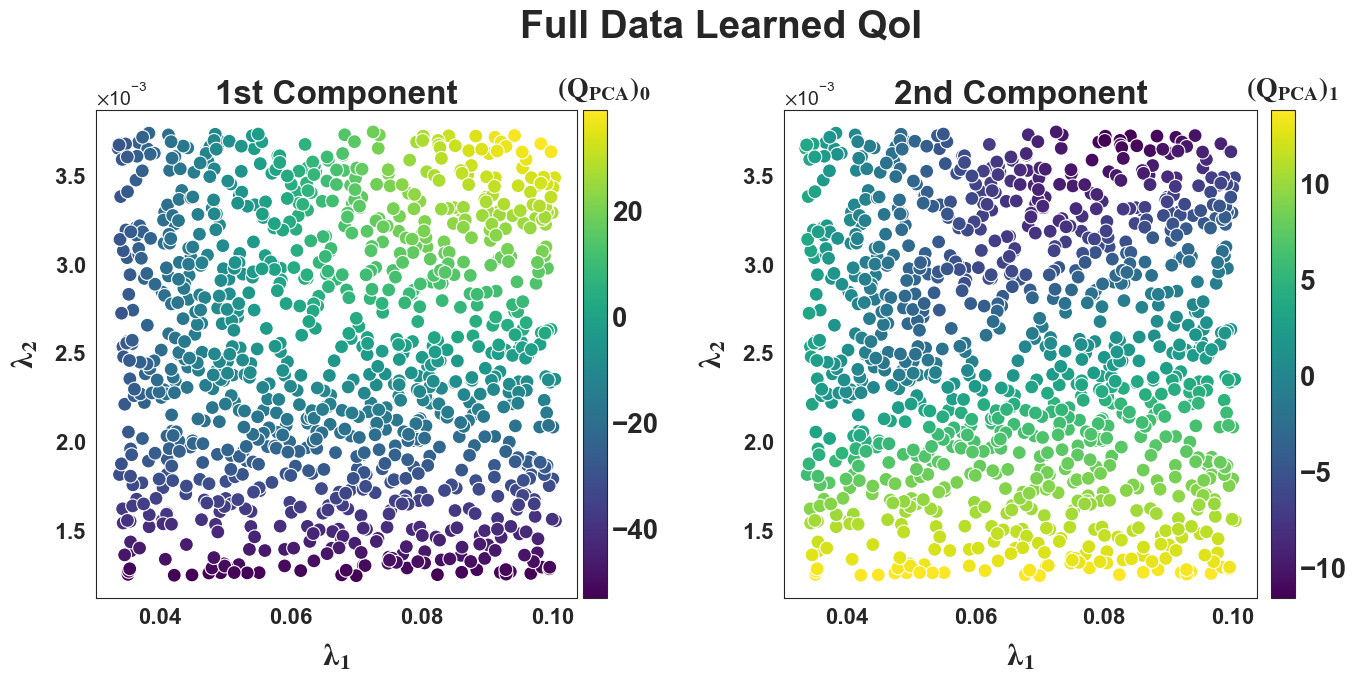

In [47]:

sns.set_palette("bright")

fig, ax = plt.subplots(1,2,figsize=(14, 7))


full_plot_settings = {
    'ax':None,
    'title':None,
    'x_lim':None,
    'y_lim':None,
    'label_pads': [10,10],
    'label_sizes': [22,22],
    'loc': [0.02, None],
    'axis_labels': [r"$\mathbf{\lambda_1}$",r"$\mathbf{\lambda_2}$"],
    'tick_label_size': 16,
    'title_pad': 4,
    'title_font_size': 24,
}


cbar1_settings = {
    "pad": 0.01,
    "label_size": 14,
    "label_pad": 40,
    "width": 0,
    "length": 0,
    "direction": "inout",
    "y": 1.07,
    "rotation": 0,
    "font_size": 20,
}

plot_pca_components(pca_df=pca[0].state, axes=ax, plot_settings=full_plot_settings, cbar_settings=cbar1_settings, fig=fig)





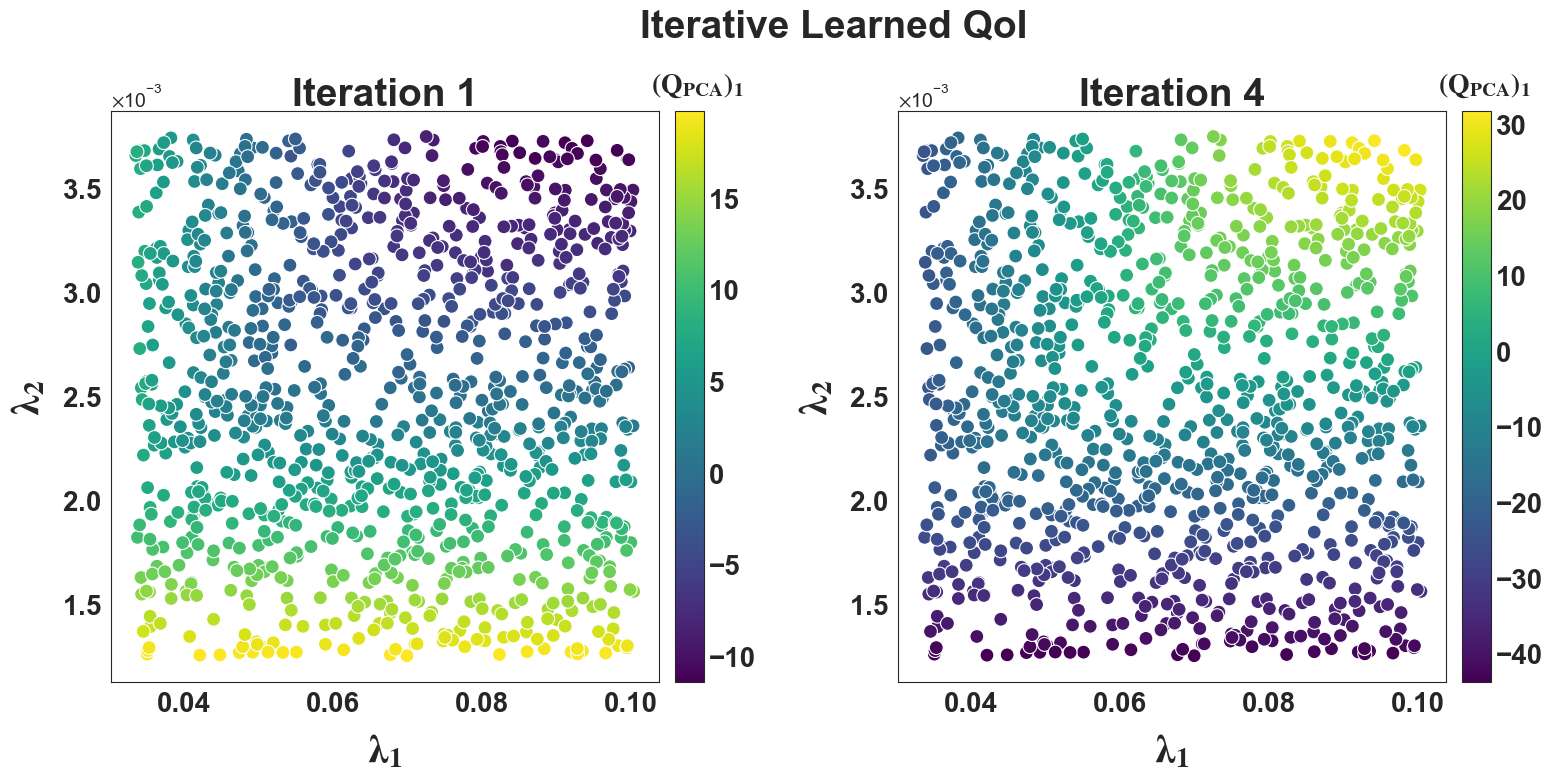

In [48]:
learn_plot_settings = {
    'ax':None,
    'title':None,
    'x_lim':None,
    'y_lim':None,
    'label_pads': [10,10],
    'label_sizes': [28,28],
    'loc': [0.02, None],
    'axis_labels': [r"$\mathbf{\lambda_1}$",r"$\mathbf{\lambda_2}$"],
    'tick_label_size': 20,
    'title_pad': 4,
    'title_font_size': 28,
}

cbar2_settings = {
    "pad": 0.025,
    "label_size": 14,
    "label_pad": 42,
    "width": 0,
    "length": 0,
    "direction": "inout",
    "y": 1.07,
    "rotation": 0,
    "font_size": 20,
}


iterations = [1, 4]
sns.set_palette("bright")
sns.set_style("white")
fig, axs = plt.subplots(1,2,figsize=(16,8))
plot_iterative_qoi(axs.flat, pca_it.states, iterations, learn_plot_settings, cbar2_settings)


___

___

In [49]:

def get_iteration_state(pca: Any, iteration: int = -1) -> pd.DataFrame:
    """
    Retrieve the state of the PCA at the specified iteration.

    Parameters
    ----------
    pca : Any
        The PCA object from which the state data is to be retrieved.
        This object is expected to have an attribute `states` which is either
        `None` or a DataFrame. It should also have a `state` attribute for the
        default state.
    iteration : int, optional
        The iteration number for which the state is to be retrieved. If set to -1,
        the last iteration's state is retrieved. By default, it is -1.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the state information for the specified iteration.
    """
    if pca.states is None:
        if iteration != -1:
            raise ValueError("The PCA object does not contain multiple states.")
        df = pca.state
    else:
        iterations = pca.states["iteration"].unique()
        if iteration < 1 or iteration > len(iterations):
            raise ValueError(f"Iteration must be between 1 and {len(iterations)}.")
        df = pca.states[pca.states["iteration"] == iterations[iteration - 1]]

    return df


def plot_kde_update(ax: Axes, 
                    data: pd.DataFrame, 
                    variable: str, 
                    weight_col: str, 
                    ratio_col: str, 
                    label: str, 
                    fill: bool, 
                    color: str, 
                    linewidth: int, 
                    alpha: float) -> None:
    """
    Plot a Kernel Density Estimate (KDE) for the specified variable with weights.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The matplotlib Axes object where the KDE will be plotted.
    data : pd.DataFrame
        The DataFrame containing the data to plot.
    variable : str
        The name of the column in `data` to plot.
    weight_col : str
        The name of the column in `data` containing the weights.
    ratio_col : str
        The name of the column in `data` containing the ratio for weighting.
    label : str
        The label for the KDE plot.
    fill : bool
        If True, fill under the KDE curve.
    color : str
        The color of the KDE plot.
    linewidth : int
        The linewidth of the KDE plot.
    alpha : float
        The alpha transparency for the fill under KDE plot.

    Returns
    -------
    None
    """
    sns.kdeplot(
        data=data,
        x=variable,
        label=label,
        weights=data[weight_col]*data[ratio_col],
        fill=fill,
        color=color,
        linewidth=linewidth,
        alpha=alpha,
        ax=ax
    )


def adjust_axis(ax: Axes,
                mud_point: float,
                lam_ref: float,
                x_loc: float,
                y_loc: float,
                x_pad: int,
                y_pad: int) -> None:
    """
    Adjusts the axis properties of a matplotlib Axes object, including plotting
    vertical lines at specified points, setting label padding, major locators,
    and tick parameters.

    Parameters
    ----------
    ax : Axes
        The Axes object to adjust.
    mud_point : float
        The x-coordinate at which to plot a vertical line representing the MUD point.
    lam_ref : float
        The x-coordinate at which to plot a vertical line representing the true parameter.
    x_loc : float
        The interval of the x-axis major locator.
    y_loc : float
        The interval of the y-axis major locator.
    x_pad : int
        The padding to add to the x-axis label.
    y_pad : int
        The padding to add to the y-axis label.

    Returns
    -------
    None
    """
    # Plot vertical lines at mean
    ax.axvline(mud_point, color='black', linestyle='-.', linewidth=2.5, label='MUD Point')
    ax.axvline(lam_ref, color='orange', linestyle='solid', linewidth=3.0, label='True Parameter')

    # Add padding to x and y labels
    ax.xaxis.labelpad = x_pad
    ax.yaxis.labelpad = y_pad

    # Set axis labels and legend
    ax.xaxis.set_major_locator(mticker.MultipleLocator(x_loc))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_loc))

    # Set tick parameters
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    # Set tick labels to bold
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

        

def create_legend(ax: Axes,
                  colors: List[str],
                  styles: List[str],
                  labels: List[str],
                  location: str = 'upper left',
                  font_size: int = 30,
                  line_width: int = 8
                  ) -> None:
    """
    Creates a custom legend for the given Axes object with specified colors,
    line styles, and labels.

    Parameters
    ----------
    ax : maxes.Axes
        The Axes object to which the legend will be added.
    colors : List[str]
        A list of color specifications for the legend lines.
    styles : List[str]
        A list of line styles for the legend lines.
    labels : List[str]
        A list of label strings for the legend entries.
    location : str, optional
        The location of the legend on the Axes. Defaults to 'upper left'.
    font_size : int, optional
        The font size of the legend labels. Defaults to 30.
    line_width : int, optional
        The line width of the legend lines. Defaults to 8.
    Returns
    -------
    None

    """
    # Create Line2D objects for the legend.
    line_handles = [mlines.Line2D([], [], color=color, linestyle=style) 
                    for color, style in zip(colors, styles)]


    # Create the legend on the Axes.
    legend = ax.legend(handles=line_handles, labels=labels, handlelength=1.8,
                       loc=location, frameon=True)


    # Set line properties in the legend.
    for idx, (line,  text, color) in enumerate(zip(legend.get_lines(), legend.get_texts(),colors)):

        
        if line.get_linestyle() == "None":
            line.set_marker('.')
            line.set_markersize(25)
            line.set_linewidth(0)   
        else:
            line.set_linewidth(line_width)
            
        line.set_color(color)  # Set the color dynamically.
        text.set_fontsize(font_size)
        text.set_fontweight('bold')

    # Directly set the linestyle for the specific line if it's known.
    legend.get_lines()[-1].set_linestyle(styles[-1])
    
    
def plot_uniform_distribution(ax: Axes, 
                              bounds: Tuple[float, float], 
                              color: str = 'grey', 
                              linestyle: str = 'solid', 
                              linewidth: int = 3) -> None:
    """
    Plot a uniform distribution on the provided axes.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The matplotlib Axes object where the distribution will be plotted.
    bounds : Tuple[float, float]
        A tuple containing the lower and upper bounds of the uniform distribution.
    color : str, optional
        The color of the distribution plot. Default is 'grey'.
    linestyle : str, optional
        The linestyle of the plot. Default is 'solid'.
    linewidth : int, optional
        The thickness of the plot and vlines. Default is 3.

    Returns
    -------
    None

    """
    lower, upper = bounds
    dist = uniform(loc=lower, scale=upper - lower)

    # plot the density function
    x = np.linspace(lower, upper, 100)
    height = dist.pdf(x).max()
    ax.plot(x, dist.pdf(x), color=color, linestyle=linestyle, lw=linewidth, zorder=1)
    ax.vlines(x=[lower, upper], ymin=0, ymax=height, color=color, linestyle=linestyle, linewidth=linewidth, zorder=2)


def plot_distributions(
    iteration: pd.DataFrame,
    legend_params: Dict[str, Any],
    fig: plt.Figure,
    axes: List[plt.Axes],
    bounds_list: List[Tuple[float, float]],
    mud_points_list: List[float],
    lam_ref_list: List[float],
    x_loc_list: List[float],
    y_loc_list: List[float],
    kde_color: str,
    plot_title: str,
    x_labels: List[str],
) -> None:
    """
    Plot uniform distributions and KDE updates for a set of axes.

    Parameters
    ----------
    iteration : pd.DataFrame
        The data frame containing iteration data.
    legnd_params : Dict[List[str], List[str],List[str]]
        List of colors, List of styles, and List of labels for the legend.
    axes : List[plt.Axes]
        The list of matplotlib axes to plot on.
    bounds_list : List[Tuple[float, float]]
        List of tuples containing the lower and upper bounds for the uniform distributions.
    mud_points_list : List[float]
        List of mud points for adjusting axes.
    lam_ref_list : List[float]
        List of lambda reference points for adjusting axes.
    x_loc_list : List[float]
        List of x locations for axis adjustment.
    y_loc_list : List[float]
        List of y locations for axis adjustment.
    x_labels : List[str]
        List of x-axis labels.
    kde_color : str
        The color of the KDE plot.
    plot_title : str
        The title of the plot.
    fig : plt.Figure
        The matplotlib figure object to set the supertitle.

    Returns
    -------
    None
        This function does not return any value. It plots on the given axes.

    """
    for i, (ax, bounds, mud_point, lam_ref, x_loc, y_loc, x_label) in enumerate(zip(axes, bounds_list, mud_points_list, lam_ref_list, x_loc_list, y_loc_list, x_labels)):

        # Plot uniform distribution and KDE
        plot_uniform_distribution(ax=ax, bounds=bounds, color='grey', linestyle='solid', linewidth=3)
        plot_kde_update(ax=ax, data=iteration, variable=f"lam_{i}", weight_col="weight", ratio_col="ratio", label="update0", fill=True, color=kde_color, linewidth=3, alpha=0.4)
        
        # Adjust axis, set labels, and create legend
        adjust_axis(ax, mud_point, lam_ref, x_loc, y_loc, x_pad=10, y_pad=10)
        ax.set_xlabel(x_label, fontsize=34)
        ax.set_ylabel('Density', fontsize=26, fontweight='bold')
        create_legend(ax, legend_params["colors"], legend_params["styles"], legend_params["labels"])

    # Set the figure's title, adjust layout and display the plot
    fig.suptitle(plot_title, fontsize=36, fontweight='bold', x=0.535, y=1.01)
    plt.tight_layout()
    plt.show()


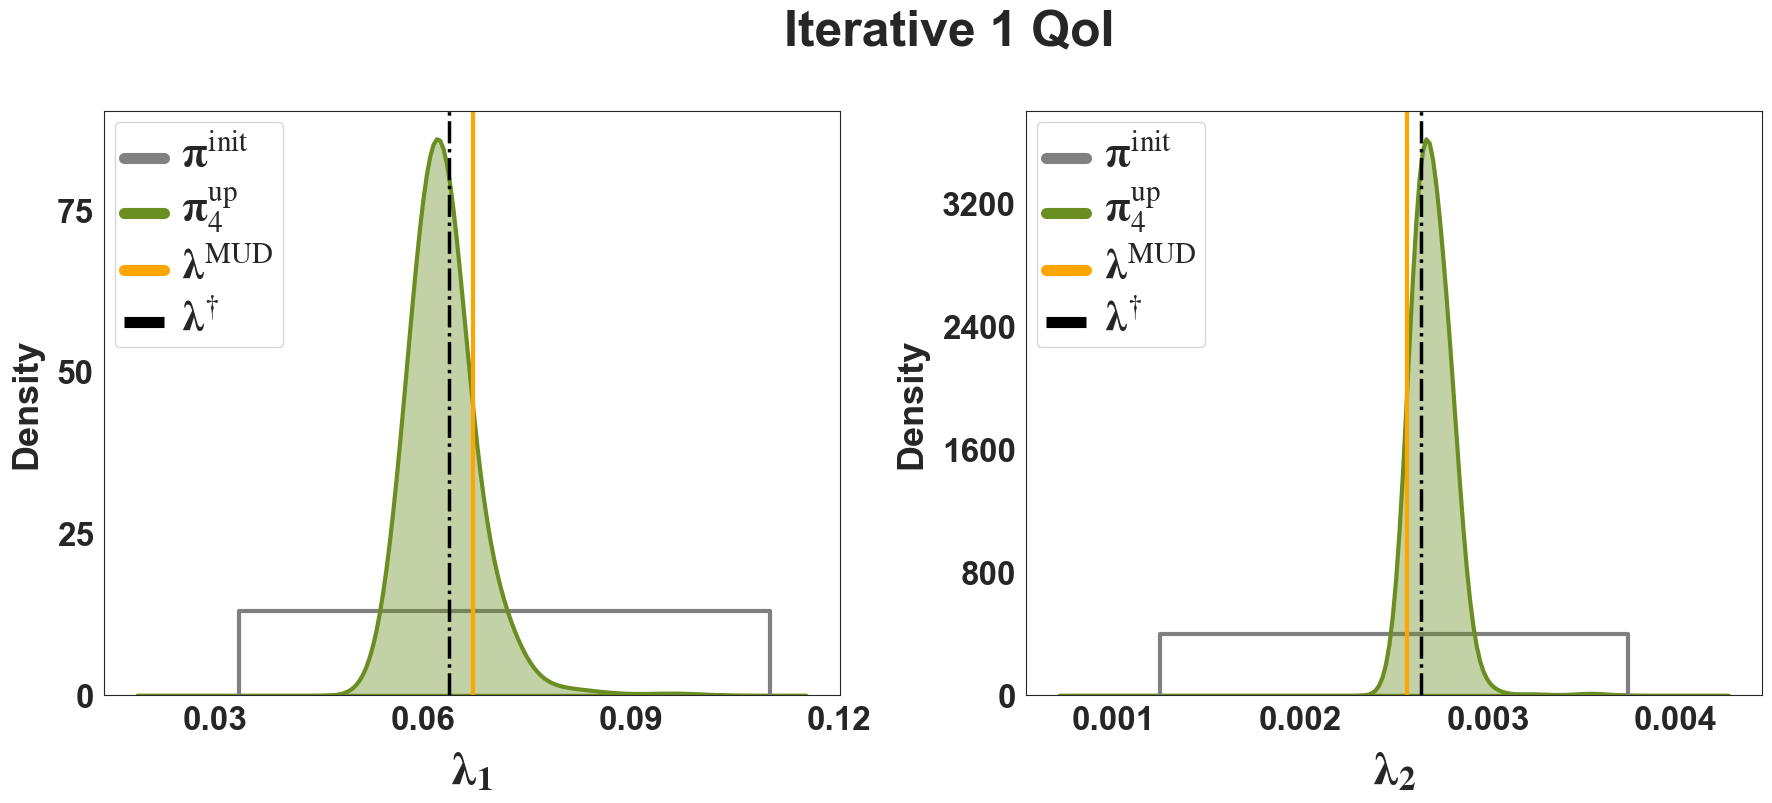

In [50]:


mud_points = pca_it.mud_point
lam_ref = get_df(data_df, "lam_true", size=2)[0]
iterations = [get_iteration_state(pca_it, iteration=i) for i in range(1, 5)]

sns.set_palette("bright")
fig, ax = plt.subplots(1,2,figsize=(18, 8))


legend_params = {
    'colors': ['grey', 'olivedrab', 'orange', 'black'],
    'styles': ['solid', 'solid', 'solid', '--'],
    'labels': [
        "$\mathbf{\pi}^{\mathrm{init}}$",
        "$\mathbf{\pi}^{\mathrm{up}}_{4}$",
        "$\mathbf{\lambda}^{\mathrm{MUD}}$",
        "$\mathbf{\lambda}^{\dagger}$"
    ]
}

subplot_params = {
    'axes': [ax[0], ax[1]],
    'bounds_list': [(0.0335, 0.110), (0.00125, 0.00375)],
    'mud_points_list': [mud_points[0], mud_points[1]],
    'lam_ref_list': [lam_ref[0], lam_ref[1]],
    'x_loc_list': [0.03, 0.001],
    'y_loc_list': [25, 800],
    'x_labels': [r'$\mathbf{\lambda_1}$', r'$\mathbf{\lambda_2}$'],
    'kde_color': 'olivedrab',
    'plot_title': 'Iterative 1 QoI',
}

plot_distributions(iterations[3], legend_params=legend_params,fig=fig, **subplot_params)


___

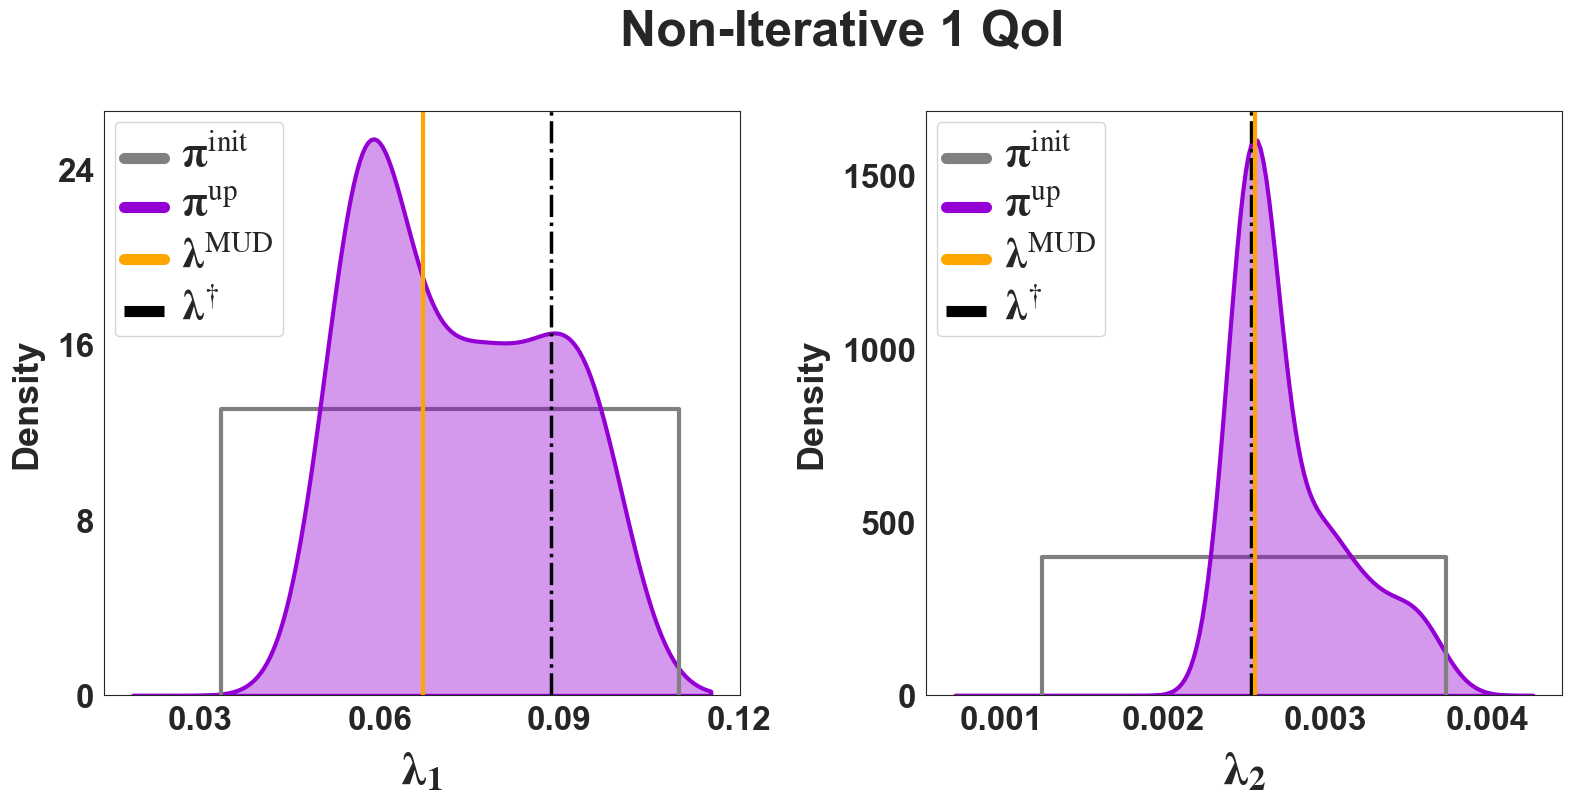

In [51]:
mud_points = pca[0].mud_point
lam_ref = get_df(data_df, "lam_true", size=2)[0]
state_df = pca[0].state


sns.set_palette("bright")
fig2, ax = plt.subplots(1,2,figsize=(16, 8))

legend_params2 = {
    'colors': ['grey', 'darkviolet', 'orange', 'black'],
    'styles': ['solid', 'solid', 'solid', '--'],
    'labels': [
        "$\mathbf{\pi}^{\mathrm{init}}$",
        "$\mathbf{\pi}^{\mathrm{up}}$",
        "$\mathbf{\lambda}^{\mathrm{MUD}}$",
        "$\mathbf{\lambda}^{\dagger}$"
    ]
}

subplot_params2 = {
    'axes': [ax[0], ax[1]],
    'bounds_list': [(0.0335, 0.110), (0.00125, 0.00375)],
    'mud_points_list': [mud_points[0], mud_points[1]],
    'lam_ref_list': [lam_ref[0], lam_ref[1]],
    'x_loc_list': [0.03, 0.001],
    'y_loc_list': [8, 500],
    'x_labels': [r'$\mathbf{\lambda_1}$', r'$\mathbf{\lambda_2}$'],
    'kde_color':'darkviolet',
    'plot_title': 'Non-Iterative 1 QoI'
}




plot_distributions(state_df, legend_params=legend_params2,fig=fig2, **subplot_params2)

____

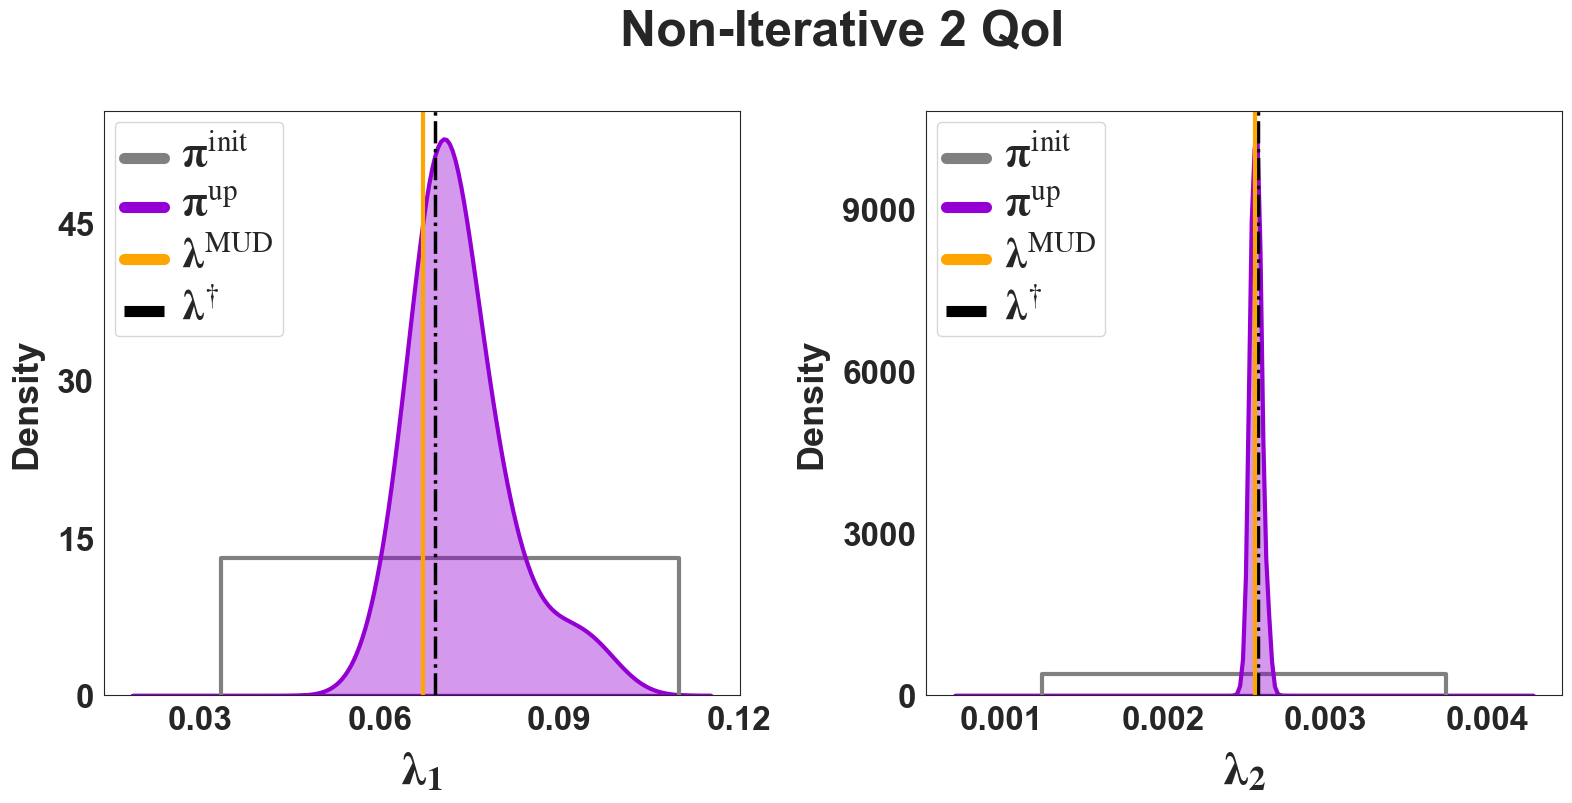

In [52]:
mud_points = pca[1].mud_point
lam_ref = get_df(data_df, "lam_true", size=2)[0]
state_df = pca[1].state


sns.set_palette("bright")
fig3, ax = plt.subplots(1,2,figsize=(16, 8))

legend_params3 = {
    'colors': ['grey', 'darkviolet', 'orange', 'black'],
    'styles': ['solid', 'solid', 'solid', '--'],
    'labels': [
        "$\mathbf{\pi}^{\mathrm{init}}$",
        "$\mathbf{\pi}^{\mathrm{up}}$",
        "$\mathbf{\lambda}^{\mathrm{MUD}}$",
        "$\mathbf{\lambda}^{\dagger}$"
    ]
}

subplot_params3 = {
    'axes': [ax[0], ax[1]],
    'bounds_list': [(0.0335, 0.110), (0.00125, 0.00375)],
    'mud_points_list': [mud_points[0], mud_points[1]],
    'lam_ref_list': [lam_ref[0], lam_ref[1]],
    'x_loc_list': [0.03, 0.001],
    'y_loc_list': [15, 3000],
    'x_labels': [r'$\mathbf{\lambda_1}$', r'$\mathbf{\lambda_2}$'],
    'kde_color':'darkviolet',
    'plot_title': 'Non-Iterative 2 QoI'
}


plot_distributions(state_df, legend_params=legend_params3,fig=fig3, **subplot_params3)

____

____

In [53]:


importlib.reload(seirs)


SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0 / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}


In [54]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 14
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=2*SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)



importlib.reload(os)
prob = os.OnlineSequential(
    sr,
    time_step=data_chunk_size,
)

prob.solve(
    num_its=52,
    max_t=None,
    num_samples=1000,
    max_sample_size=2000,
    samples_inc=None,
    time_step=data_chunk_size,
    exp_thresh=0.1,
    kl_thresh=3.0,
    min_eff_sample_size=0.9,
    num_tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[1, 2, 3],
        split_range=[1],
        all_data=True,
    ),
    make_plots=False,
    seed=2023,
    reset_model=True,
    reset_samples=False,
)

Solving model sample set: |                    | ▁▃▅ 0/1000 [0%] in 0s (~0s, 0.0

In [55]:
def plot_state(
    problem: str,  # Replace ProblemType with the actual type
    size_dict: dict,
    state_idx: int = 0,
    plot_true: bool = True,
    plot_measurements: bool = True,
    plot_predictions: bool = False,
    plot_iterations: bool = True,
    plot_shifts: bool = True,
    n_samples: int = 10,
    iterations: Optional[List[int]] = None,
    markersize: int = 100,
    window_type: str = "lines",
    figsize: Union[tuple, list] = (9, 8),
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """
    Plots the state at a certain index over time, including true states,
    measurements, predictions, and iterations.

    Parameters:
        problem: str
            The problem containing the data to plot.
        size_dict: dict
            Dictionary containing size information for the plot.
        plot_true: bool, default True
            Whether to plot the true state.
        plot_measurements: bool, default True
            Whether to plot the measurements.
        plot_predictions: bool, default True
            Whether to plot the predictions.
        plot_iterations: bool, default True
            Whether to plot iterations.
        plot_shifts: bool, default True
            Whether to plot shifts.
        n_samples: int, default 10
            Number of samples to draw.
        state_idx: int, default 0
            Index of the state to plot.
        iterations: Optional[List[int]]
            List of iterations to plot. If None, plots all iterations.
        window_type: WindowType, default "lines"
            The type of window to use for plotting.
        markersize: int, default 100
            Size of the markers in the plot.
        figsize: Union[tuple, list], default (9, 8)
            Figure size for the plot.
        ax: Optional[plt.Axes]
            Existing axes to plot on. If None, creates a new figure and axes.

    Returns:
        plt.Axes
            The axes with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        

    max_it = len(problem.data) - 1
    iterations = np.arange(max_it + 1) if iterations is None else iterations
    
    if plot_iterations:
        print("plotting iterations")
        plot_iters(problem, iterations, ax)
    if plot_shifts:
        plot_shift_lines(problem, iterations, size_dict, ax)
    if plot_true:
        plot_true_state(problem, iterations, state_idx, max_it, size_dict, ax)
    if plot_measurements:
        plot_observations(problem, iterations, state_idx, max_it, size_dict, ax)
    if plot_predictions:
        plot_predictions(problem, iterations, state_idx, size_dict, ax)
    return ax



def plot_iters(problem: Any, iterations: List[int], ax: Axes) -> None:
    """
    Plot iteration lines on a given Axes object.

    Parameters
    ----------
    problem : Any
        An object containing the problem data. It should have a 'data' attribute 
        that is a list of DataFrames, indexed by iteration numbers provided in 'iterations'.
    iterations : List[int]
        A list of integers representing the iterations to plot.
    size_dict : Dict[str, Any]
        A dictionary that may contain size-related information for plotting. 
        The content of this dictionary is not used in this function, but it is passed 
        for potential use and consistency with other plotting functions.
    ax : Axes
        The matplotlib Axes object on which to plot the iteration lines.

    Returns
    -------
    None

    """
    
    for iteration in iterations:

        df: pd.DataFrame = problem.data[iteration]   
        ax.axvline(
            x=df["ts"].min(),
            linestyle="solid",
            color="darkgoldenrod",
            alpha=0.5,
            label=None,
        )


def plot_observations(
    problem: Any, 
    iterations: List[int], 
    state_idx: int, 
    max_it: int, 
    size_dict: Dict[str, int], 
    ax: Axes
) -> None:
    """
    Plot observations on a matplotlib Axes object for the specified state index and iterations.

    Parameters
    ----------
    problem : Any
        An object representing the problem context. It must have a 'data' attribute, 
        which is a list of DataFrames corresponding to different iterations, and a
        'state_idxs' attribute, which contains the indices of the states.
    iterations : List[int]
        A list of iteration numbers for which to plot the observations.
    state_idx : int
        The index of the state for which observations are to be plotted.
    max_it : int
        The maximum iteration number from the problem data to define the label.
    size_dict : Dict[str, int]
        A dictionary containing plotting parameters such as marker size.
    ax : Axes
        The matplotlib Axes object on which the observations will be plotted.

    Returns
    -------
    None

    """
    
    for iteration in iterations:
        df: pd.DataFrame = problem.data[iteration]
            
        # Add Measurement Data to the plot
        if state_idx in problem.state_idxs:
            label: str = None if iteration != max_it else "Measurements"
            # Get index of state_idx in list problem.state_idxs
            obs_idx: int = np.where(problem.state_idxs == state_idx)[0][0]
            sns.scatterplot(
                x="ts",
                y=f"q_lam_obs_{obs_idx}",
                ax=ax,
                color="black",
                data=df,
                marker=".",
                s=size_dict['obs_marker_size'],
                label=label,
                zorder=4,
            )



def plot_shift_lines(
    problem: Any, 
    iterations: List[int], 
    size_dict: Dict[str, int], 
    ax: Axes
) -> None:
    """
    Plot vertical lines representing shifts on a matplotlib Axes object for specified iterations.

    Parameters
    ----------
    problem : Any
        An object representing the problem context. It must have a 'data' attribute,
        which is a list of DataFrames corresponding to different iterations, and a
        'param_shifts' attribute, which contains the times of parameter shifts.
    iterations : List[int]
        A list of iteration numbers for which to plot the shift lines.
    size_dict : Dict[str, int]
        A dictionary containing plotting parameters such as line width.
    ax : Axes
        The matplotlib Axes object on which the shift lines will be plotted.

    Returns
    -------
    None
        This function does not return any value. It modifies the provided Axes object in place.

    Examples
    --------
    >>> plot_shift_lines(problem=my_problem, iterations=[0, 1, 2], 
                          size_dict={'shift_line_width': 2}, ax=my_ax)
    This will plot vertical lines at the times of parameter shifts for iterations 0, 1, and 2 on the Axes object 'my_ax'.
    """

    for iteration in iterations:
        df: pd.DataFrame = problem.data[iteration]
        shift_times = df["ts"][(df["shift_idx"] - df["shift_idx"].shift(1)) == 1]
        if len(shift_times) > 0:
            for t in shift_times:
                label = "Shift" if t >= max(problem.param_shifts.keys()) else None
                ax.axvline(
                    x=t,
                    linewidth=size_dict['shift_line_width'],
                    color="crimson",
                    label=label
                )

def plot_states(problem: Any, size_dict: Dict[str, float], base_size: int = 5, **kwargs) -> None:
    """
    Plot states over time on a grid layout.

    Parameters
    ----------
    problem : Any
        The problem object containing the state information.
    size_dict : dict
        A dictionary with sizing information for the plots.
    base_size : int, optional
        The base size for the subplot, by default 5.
    **kwargs : dict
        Additional keyword arguments passed to the plotting function.

    Returns
    -------
    None
        This function doesn't return anything, it shows/plots the states.
    """
    grid_plot = closest_factors(problem.n_states)
    fig, ax = plt.subplots(
        grid_plot[0],
        grid_plot[1],
        figsize=(grid_plot[0] * (base_size + 2), grid_plot[0] * base_size),
    )
    for i, ax in enumerate(ax.flat):
        plot_state(problem, size_dict, state_idx=i, ax=ax, **kwargs)
        ax.set_title(f"State {i}: Temporal Evolution")


def plot_true_state(problem: Any, iterations: Any, state_idx: int, max_it: int, size_dict: Dict[str, float], ax: plt.Axes) -> None:
    """
    Plot the true state of a given index over iterations on the provided axis.

    Parameters
    ----------
    problem : Any
        The problem object containing the state information.
    iterations : Any
        An iterable containing iteration indices.
    state_idx : int
        The index of the state to plot.
    max_it : int
        The maximum number of iterations.
    size_dict : dict
        A dictionary with sizing information for the plots.
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib axis where the plot will be drawn.

    Returns
    -------
    None
        This function doesn't return anything, it plots the true state on the axis.
    """
    for iteration in iterations:
        df = problem.data[iteration]
        sns.lineplot(
            x="ts",
            y=f"q_lam_true_{state_idx}",
            ax=ax,
            color="darkviolet",
            data=df,
            linewidth=size_dict['state_line'],
            label="True State" if iteration == max_it else None,
            zorder=2
        )


def plot_infected(problem: Any, size_dict: Dict[str, float], **kwargs) -> plt.Axes:
    """
    Plot the infected population state over time.

    Parameters
    ----------
    problem : Any
        The problem object containing the state information.
    size_dict : dict
        A dictionary with sizing information for the plots.
    **kwargs : dict
        Additional keyword arguments passed to the plotting function.

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot
        The matplotlib axis with the infected population state plot.
    """
    ax = plot_state(problem, size_dict, state_idx=2, **kwargs)
    return ax


def format_axis(ax: axes.Axes, x_label: str, y_label: str, title: str,
                x_lim: Tuple[int, int], y_lim: List[float], 
                x_tick_locator: int, y_tick_locator: float,
                label_fontsize: int = 24, title_fontsize: int = 32, 
                tick_labelsize: int = 24, pad: int = 7) -> None:
    """
    Format the x and y axis of a matplotlib Axes object.

    Parameters
    ----------
    ax : Axes
        The matplotlib Axes object to be formatted.
    x_label : str
        Label for the x-axis.
    y_label : str
        Label for the y-axis.
    title : str
        Title of the Axes.
    x_lim : Tuple[int, int]
        Limits for the x-axis as a tuple of (min, max).
    y_lim : List[float]
        Limits for the y-axis as a list [min, max].
    x_tick_locator : int
        Major tick locator for the x-axis.
    y_tick_locator : float
        Major tick locator for the y-axis.
    label_fontsize : int, optional
        Font size for the axis labels.
    title_fontsize : int, optional
        Font size for the title.
    tick_labelsize : int, optional
        Font size for the tick labels.
    pad : int, optional
        Padding for the title.

    Returns
    -------
    None

    """
    # Set axis limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    # Set axis labels and title
    ax.set_xlabel(x_label, fontsize=label_fontsize, fontweight="bold")
    ax.set_ylabel(y_label, fontsize=label_fontsize, fontweight="bold")
    ax.set_title(title, fontsize=title_fontsize, fontweight="bold", pad=pad)
    
    # Configure major tick locators
    ax.xaxis.set_major_locator(mticker.MultipleLocator(x_tick_locator))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_locator))
    
    # Configure tick parameters and label font properties
    ax.tick_params(axis='x', labelsize=tick_labelsize)
    ax.tick_params(axis='y', labelsize=tick_labelsize)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')



def add_text_to_axis(ax: axes.Axes, text: str, offset_x: float, 
                     offset_y: float, color: str = "crimson", 
                     fontsize: int = 20, fontweight: str = "bold") -> None:
    """
    Add a text label to the axes at a position offset from the lower left corner.

    Parameters
    ----------
    ax : Axes
        The matplotlib Axes object to which the text will be added.
    text : str
        The text to be added.
    offset_x : float
        The offset from the left of the x-axis to place the text.
    offset_y : float
        The offset from the bottom of the y-axis to place the text.
    color : str, optional
        The color of the text. Default is "crimson".
    fontsize : int, optional
        The font size of the text. Default is 20.
    fontweight : str, optional
        The font weight of the text. Default is "bold".

    Returns
    -------
    None

    """
    # Get current xlim and ylim
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Set the text at the specified offset from the lower left corner
    ax.text(xlim[0] + offset_x, ylim[0] + offset_y, text, 
            fontsize=fontsize, fontweight=fontweight, color=color)


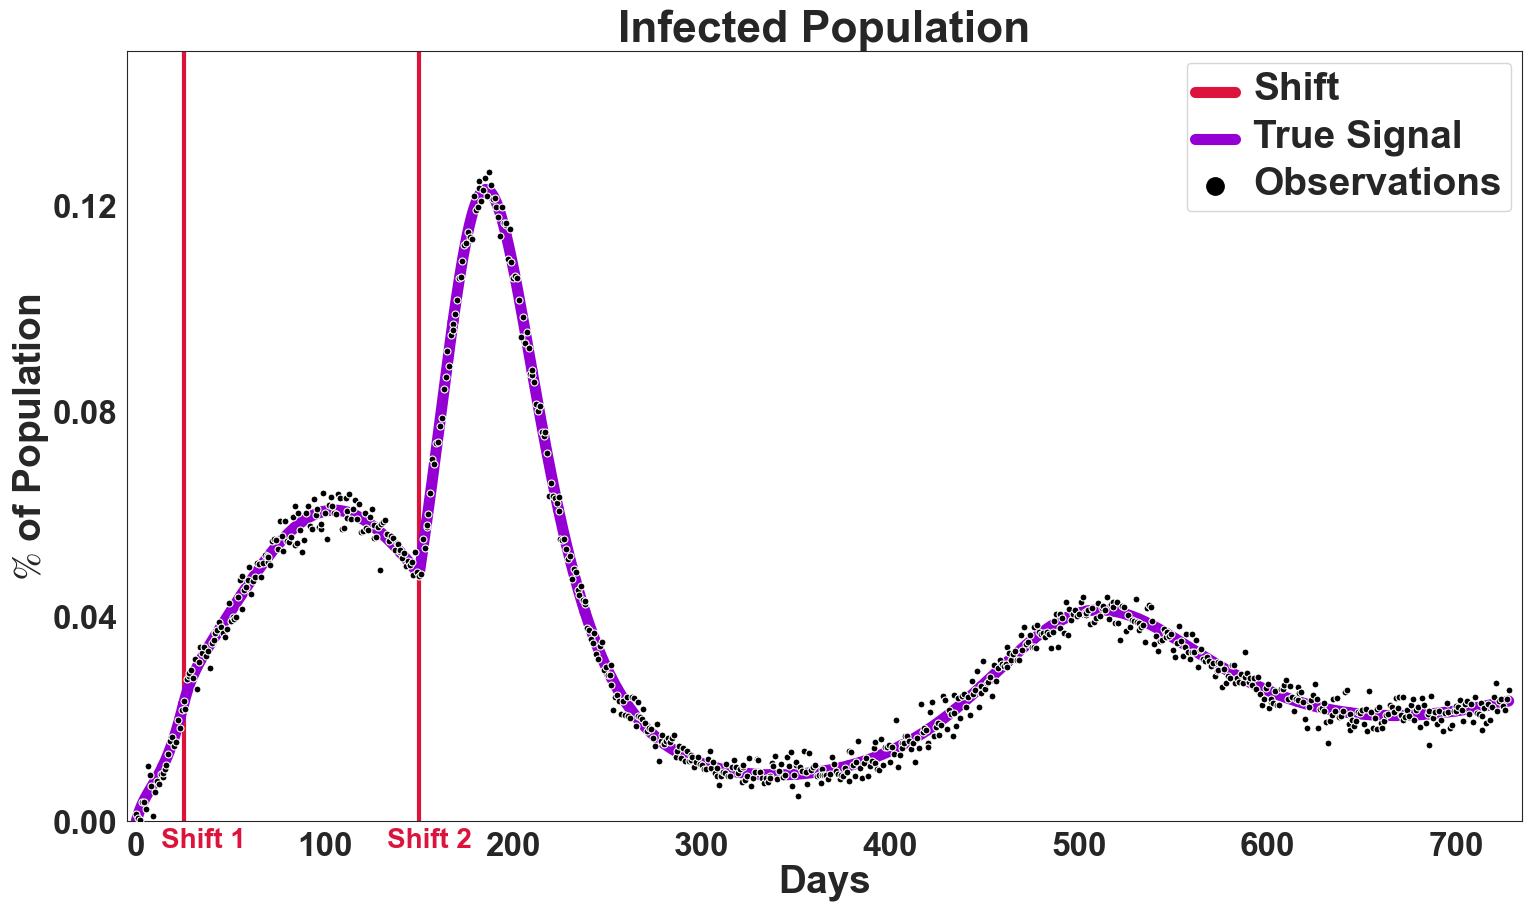

In [56]:
sns.set_palette("bright")
size_dict = {"state_line":8, "obs_marker_size":100, "predict_marker_size":8, "shift_line_width":3}
labels = ["Shift",
        "True Signal",
        "Observations"
        ]
styles = ["solid","solid","None"]
colors = ["crimson","darkviolet","black"]

ax = plot_infected(
                prob.model,
                size_dict,
                plot_true=True,
                plot_measurements=True,
                plot_predictions=False,
                plot_iterations=False,
                plot_shifts=True,
                figsize=(18,10), 
                n_samples=10,
                markersize=5)


format_axis(ax, "Days", "$\%$ of Population", "Infected Population", (-5, 735), [0,0.15], 100, 0.04, label_fontsize=28, title_fontsize=32, tick_labelsize=24, pad=7)
create_legend(ax, colors, styles, labels, location='upper right', font_size=28, line_width=8)
add_text_to_axis(ax, "Shift 1", 18, -0.005, color="crimson", fontsize=20, fontweight="bold")
add_text_to_axis(ax, "Shift 2", 138, -0.005, color="crimson", fontsize=20, fontweight="bold")





plotting iterations


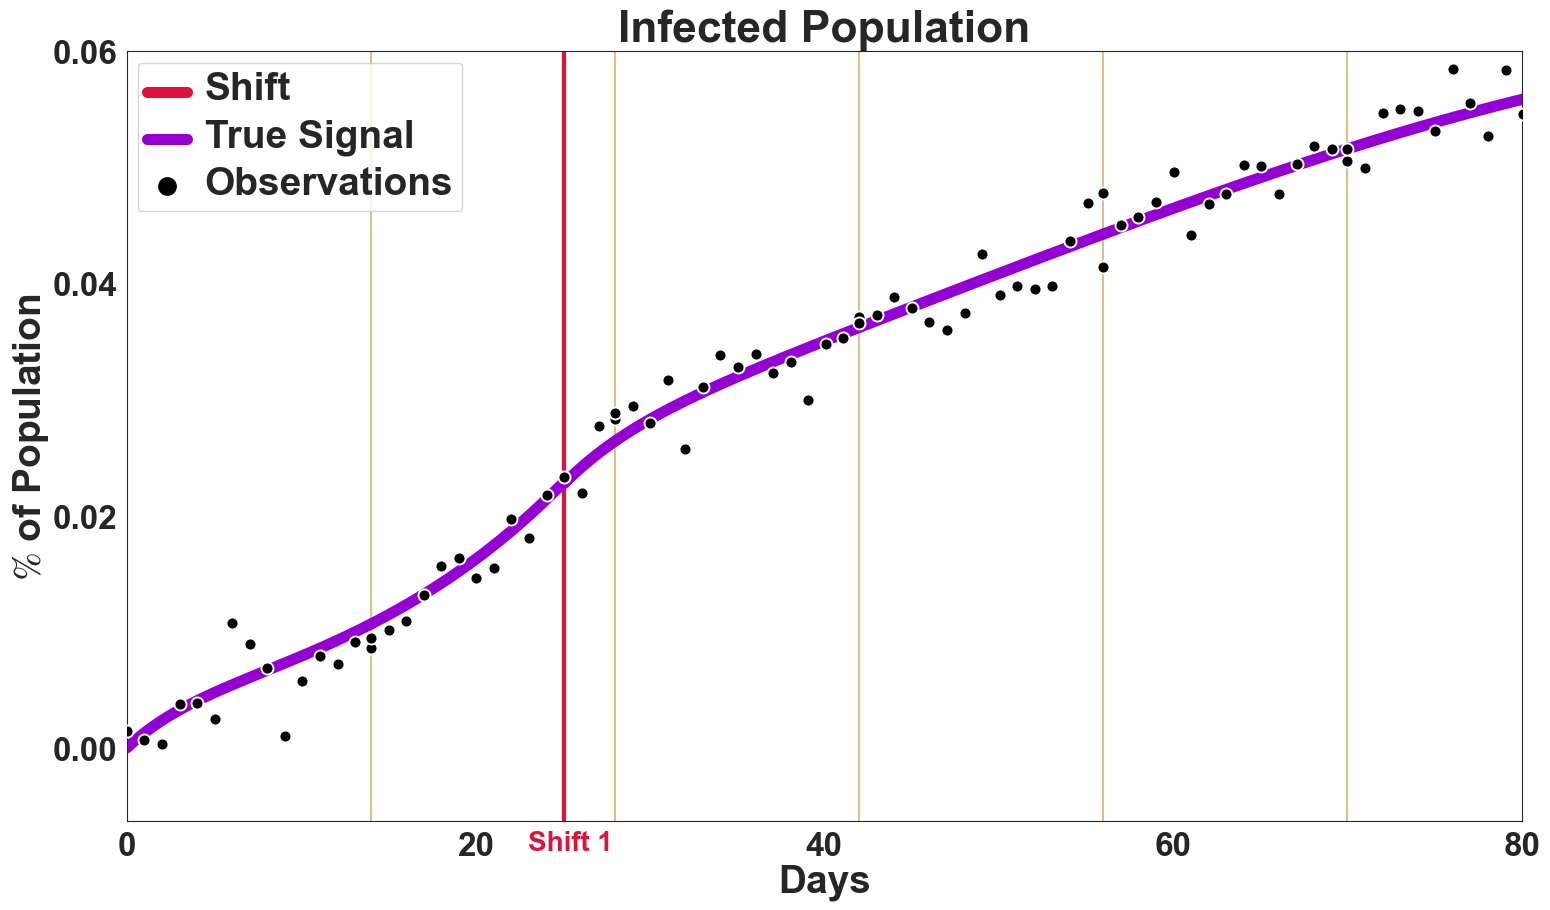

In [57]:
sns.set_palette("bright")
size_dict = {"state_line":8, "obs_marker_size":300, "predict_marker_size":8, "shift_line_width":3}
first_shift = [0, 80]
labels = ["Shift",
        "True Signal",
        "Observations"
        ]
styles = ["solid","solid","None"]
colors = ["crimson","darkviolet","black"]

ax2 = plot_infected(
                prob.model,
                size_dict,
                plot_true=True,
                plot_measurements=True,
                plot_predictions=False,
                plot_iterations=True,
                plot_shifts=True,
                figsize=(18,10), 
                n_samples=10,
                markersize=5)

format_axis(ax2, "Days", "$\%$ of Population", "Infected Population", first_shift, [ax2.get_ylim()[0], 0.06], 20, 0.02, label_fontsize=28, title_fontsize=32, tick_labelsize=24, pad=7)
create_legend(ax2, colors, styles, labels, location='upper left', font_size=28, line_width=8)
add_text_to_axis(ax2, "Shift 1", 23, -0.0025, color="crimson", fontsize=20, fontweight="bold")
plt.show()




plotting iterations


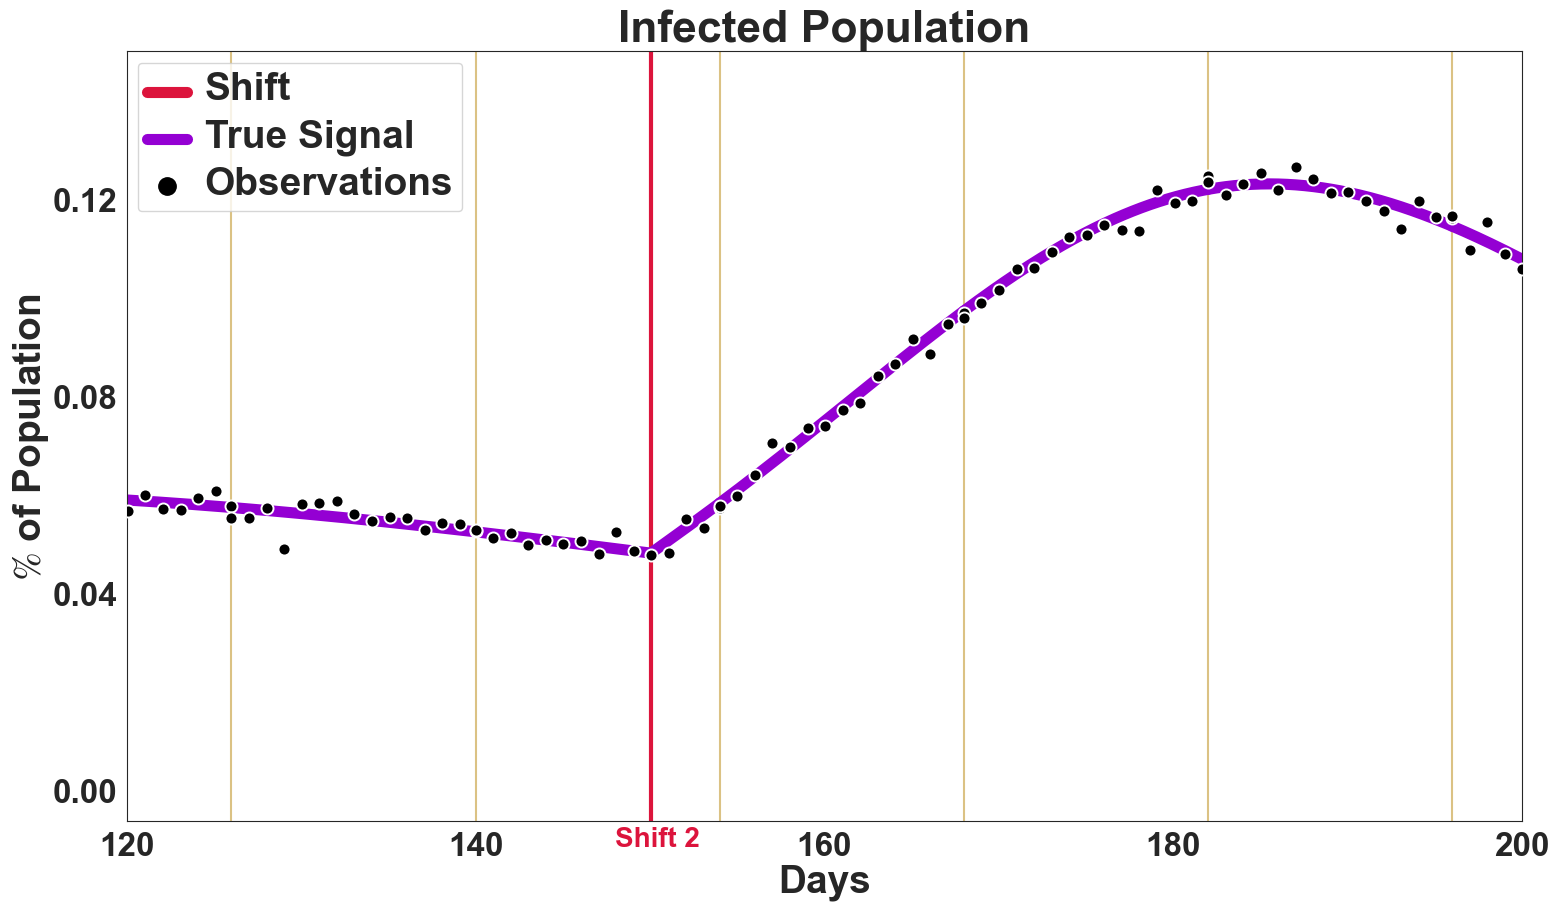

In [58]:
sns.set_palette("bright")
size_dict = {"state_line":8, "obs_marker_size":300, "predict_marker_size":8, "shift_line_width":3}
second_shift = [120, 200]

labels = ["Shift",
        "True Signal",
        "Observations"
        ]
styles = ["solid","solid","None"]
colors = ["crimson","darkviolet","black"]

ax3 = plot_infected(
                prob.model,
                size_dict,
                plot_true=True,
                plot_measurements=True,
                plot_predictions=False,
                plot_iterations=True,
                plot_shifts=True,
                figsize=(18,10), 
                n_samples=10,
                markersize=5)



format_axis(ax3, "Days", "$\%$ of Population", "Infected Population", second_shift, [ax3.get_ylim()[0], 0.15], 20, 0.04, label_fontsize=28, title_fontsize=32, tick_labelsize=24, pad=7)
create_legend(ax3, colors, styles, labels, location='upper left', font_size=28, line_width=8)
add_text_to_axis(ax3, "Shift 2", 28, -0.005, color="crimson", fontsize=20, fontweight="bold")



____


____

In [59]:
def e_r_plot(
        problem: Any, 
        shifts: Sequence[float],
        results: Optional[pd.DataFrame] = None, 
        e_r_thresh: Optional[float] = None, 
        x_vals: str = 'data_idx', 
        ax: Optional[plt.Axes] = None, 
        plot_settings: Optional[dict] = None
    ) -> None:
    """
    Plot the expected ratio (e_r) against provided x values with optional threshold lines.

    Parameters
    ----------
    problem : Problem
        An instance of the problem class containing problem-specific methods and attributes.
    shifts : Sequence[float]
        A sequence of shift values to plot as vertical lines.
    results : pd.DataFrame, optional
        A DataFrame containing the results to plot. If None, concatenate iterative results from `problem`.
    e_r_thresh : float, optional
        The threshold for the expected ratio, used to draw dashed horizontal lines.
    x_vals : str, default 'data_idx'
        The name of the column in `results` DataFrame to be used as x-axis values.
    ax : matplotlib.axes.Axes, optional
        The axes on which to draw the plot. If None, a new figure and axes are created.
    plot_settings : dict, optional
        A dictionary of additional plot settings to apply.

    Returns
    -------
    None
        The function does not return any values but plots the expected ratio chart.

    """
    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    if results is None:
        results = pd.concat(problem.it_results)

    # plot vertical line
    ax.vlines(
        shifts,
        ymin=0,
        ymax=1.5,
        color="crimson",
        linestyle="solid",
        linewidth=2,
        alpha=0.8,
        zorder=1,
    )
    sns.lineplot(
        results, x=x_vals, y='e_r', ax=ax, label="Iterative Expected Ratio", marker="o", markersize=8.5, zorder=3
    )
    xlims = ax.get_xlim()
    if e_r_thresh is not None:
        crimson_lines = ax.hlines(
            [1 + e_r_thresh, 1 - e_r_thresh],
            xmin=xlims[0],
            xmax=xlims[1],
            color="dimgray",
            linestyle="dashed",
            label="Threshold $|1 - \mathbb{E}(r)|$",
            alpha=1,
            zorder=2
        )
    ax.hlines(
        [1],
        xmin=xlims[0],
        xmax=xlims[1],
        color="black",
        linestyle=":",
        linewidth=2,
        label="Predictability Assumption $\mathbb{E}(r)$ ≈ 1",
        zorder=2
    )
            
    plot_settings.update({'ax':ax})
    add_plot_settings(**plot_settings)
    ax = plot_settings['ax']

    ax.legend().set_visible(False)
    
    
    # plot_epsilon_arrows
    ax.arrow(xlims[0]+36.8 , 1.25, 0, -0.1, head_width=0.5, head_length=0.02,fc='black', ec='black')
    ax.arrow(xlims[0]+36.8, 0.75, 0, 0.1, head_width=0.5, head_length=0.02,fc='black', ec='black')
    ax.text(xlims[0] + 35.95, 1.3, "$\epsilon_{\mathrm{pred}}$", fontsize=24, fontweight="bold")
    ax.text(xlims[0] + 35.95, 0.67, "$\epsilon_{\mathrm{pred}}$", fontsize=24, fontweight="bold")

    add_text_to_axis(ax, "Shift 1", 1.28, -0.05, color="crimson", fontsize=14, fontweight="bold")
    add_text_to_axis(ax, "Shift 2", 8.95, -0.05, color="crimson", fontsize=14, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


def kl_plot(
        problem: Any,
        shifts: Sequence[float],
        plot_settings: Optional[dict] = None,
        results: Optional[pd.DataFrame] = None,
        kl_thresh: Optional[float] = None,
        x_vals: str = 'data_idx',
    ) -> None:
    """
    Plot the Kullback-Leibler divergence (KL) against provided x values with optional threshold lines.

    Parameters
    ----------
    problem : Problem
        An instance of the problem class containing problem-specific methods and attributes.
    shifts : Sequence[float]
        A sequence of shift values to plot as vertical lines.
    plot_settings : dict, optional
        A dictionary of additional plot settings to apply.
    results : pd.DataFrame, optional
        A DataFrame containing the results to plot. If None, concatenate iterative results from `problem`.
    kl_thresh : float, optional
        The threshold for the KL divergence, used to draw a dashed horizontal line.
    x_vals : str, default 'data_idx'
        The name of the column in `results` DataFrame to be used as x-axis values.

    Returns
    -------
    None
        The function does not return any values but plots the KL divergence chart.
    """


    fig, ax = plt.subplots(figsize=(12, 6))

    if results is None:
        results = pd.concat(problem.it_results)

    sns.lineplot(
        results,
        x=x_vals,
        y='kl',
        color="green",
        ax=ax,
        marker="o",
        markersize=8.5,
        zorder=3
    )
    xlims = ax.get_xlim()
    if kl_thresh is not None:
        ax.hlines(
            [kl_thresh],
            xmin=xlims[0],
            xmax=xlims[1],
            color="black",
            linestyle=":",
            linewidth=3,
            zorder=2,
        )


    ax.vlines(shifts, ymin=-3, ymax=15, color="crimson", linestyle="solid", linewidth=2, alpha=0.8, zorder=1)


    plot_settings.update({'ax':ax})
    add_plot_settings(**plot_settings)
    ax = plot_settings['ax']

    ax.arrow(xlims[1]-20 , 4.5, 0, -1, head_width=0.4, head_length=0.2,fc='black', ec='black')
    ax.text(xlims[1] - 21, 5, "$\epsilon_{\delta - \mathrm{point}}$", fontsize=30, fontweight="bold")
    
    add_text_to_axis(ax, "Shift 1", 1.5,-0.5, color="crimson", fontsize=14, fontweight="bold")
    add_text_to_axis(ax, "Shift 2", 9, -0.5, color="crimson", fontsize=14, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


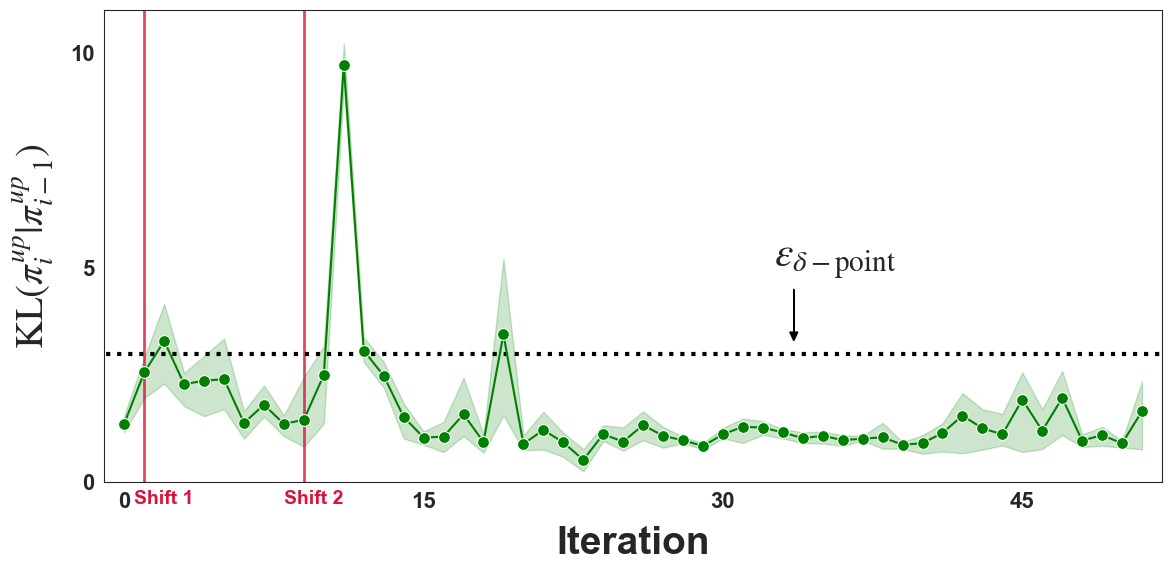

In [60]:
shifts = [1,9]

kl_plot_settings = {
    'ax':None,
    'title':None,
    'x_lim':[-1, 52],
    'y_lim':[0,11],
    'label_pads': [10,10],
    'label_sizes': [28,28],
    'loc': [15,5],
    'axis_labels': ["Iteration",r"$\mathrm{KL}(\pi^{up}_i | \pi^{up}_{i-1})$"],
    'tick_label_size': 16,
    'title_pad': 4,
    'title_font_size': 28,
}

kl_plot(prob,shifts, plot_settings= kl_plot_settings, kl_thresh=3.0)

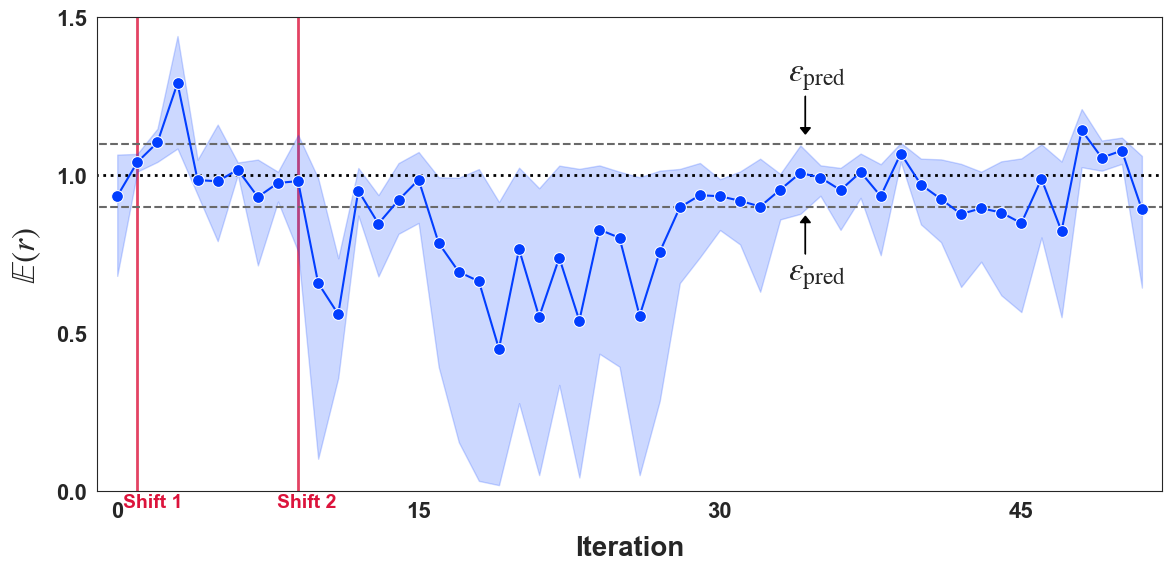

In [61]:
sns.set_palette("bright")
shifts = [1,9]
er_plot_settings = {
    'ax':None,
    'title':None,
    'x_lim':[-1, 52],
    'y_lim':[0, 1.5],
    'label_pads': [10,10],
    'label_sizes': [20,24],
    'loc': [15,.5],
    'axis_labels': ["Iteration",r"$\mathbb{E}(r)$"],
    'tick_label_size': 16,
    'title_pad': None,
    'title_font_size': 28,
}

e_r_plot(prob,shifts,e_r_thresh=0.1, plot_settings= er_plot_settings)

____

____

In [62]:


def plot_param_density(
    problem: Any,  # Replace 'YourType' with the actual type of the 'problem' parameter
    probs: Optional[Union[np.ndarray, List[Any]]] = None,  # Replace 'YourOtherType' with the actual type
    param_idx: int = 0,
    idxs: Optional[np.ndarray] = None,
    figsize: Tuple[int, int] = (5, 5),
    lam_true: Optional[List[Union[int, Tuple[int, np.ndarray]]]] = None,
    ax: Optional[Axes] = None
) -> Axes:
    """
    Plot the density of parameters for a given problem instance.

    Parameters
    ----------
    problem : YourType
        The problem instance for which the parameters' density is to be plotted.
    probs : Optional[Union[np.ndarray, List[YourOtherType]]], optional
        Probabilities or objects containing the probability information. Defaults to None, which uses `problem.probs`.
    param_idx : int, optional
        The index of the parameter to plot. Defaults to 0.
    idxs : Optional[np.ndarray], optional
        Indices of the probabilities to use for plotting. Defaults to None, which uses all indices.
    figsize : Tuple[int, int], optional
        The figure size for the plot. Defaults to (5, 5).
    lam_true : Optional[List[Union[int, Tuple[int, np.ndarray]]]], optional
        True parameter values to be plotted as vertical lines. Defaults to None.
    ax : Optional[Axes], optional
        The axes on which to plot the density. If None, a new figure and axes are created. Defaults to None.

    Returns
    -------
    Axes
        The axes with the density plot.



    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    probs = problem.probs if probs is None else probs

    # Plot initial at first iteration
    labels = []
    idxs = np.arange(len(probs)) if idxs is None else idxs
    if len(idxs) > 2:
        alphas = np.linspace(0.1, 0.9, len(idxs))
        for i, j in enumerate(idxs[1:-1]):
            if isinstance(probs[j], OfflineSequential):  # Replace 'OfflineSequential' with the actual type if needed
                _, l = probs[j].plot_L(
                    ax=ax,
                    param_idx=param_idx,
                    initial_kwargs=None,
                    update_kwargs={
                        "color": "orange",
                        "alpha": 1,
                        "linestyle": "--",
                        "fill": False,
                    },
                    plot_legend=False,
                    mud_kwargs=None,
                    lam_true=None,
                )
                labels += [f"$\pi^{{up}}_{{{j}}}$"]
    # plot update at final iteration
    _, l = probs[idxs[-1]].plot_L(
        ax=ax,
        param_idx=param_idx,
        initial_kwargs=None,
        update_kwargs={"color": "olivedrab", "linestyle": "-", "fill": True, "alpha": 0.5, "linewidth": 3},
        plot_legend=False,
        mud_kwargs={"color": "orange", "linestyle": "solid"},
        lam_true=None,
    )
    labels += [f"$\pi^{{up}}$", "$\lambda^{mud}$"]
    if lam_true is not None:
        for l in lam_true:
            colors = ["black", "black", "black"]
            if len(l) == 2:
                ax.axvline(
                    x=l[1][param_idx],
                    linewidth=3,
                    color=colors[l[0]],
                    linestyle="--",
                )
                labels += [f"$\lambda^{{\dagger}}_{{{l[0]}}}$"]
            else:
                ax.axvline(
                    x=l[param_idx],
                    linewidth=3,
                    color="black",
                    linestyle="--",
                )
                labels += [f"$\lambda^{{\dagger}}$"]
    return ax


In [63]:
def plot_param_densities(prob, param_idx, lam_trues, idxs, axs):
    """
    Plot parameter densities on given axes.

    Parameters
    ----------
    prob : Problem
        An instance of the problem containing probabilities and other information.
    param_idx : int
        The index of the parameter to plot the density for.
    lam_trues : list of lists of tuples
        Each list contains tuples of (parameter index, parameter value) pairs representing the true values.
    idxs : list of lists of int
        Each list contains indices to be used in the plot_param_density function.
    axs : numpy.ndarray of matplotlib.axes.Axes
        A 2D array of axes objects on which to plot the densities.

    Returns
    -------
    None
    """
    for lam_true, idx, ax in zip(lam_trues, idxs, axs.flatten()):
        plot_param_density(
            problem=prob,
            probs=[p.best for p in prob.probs],
            param_idx=param_idx,
            idxs=idx,
            lam_true=lam_true,
            ax=ax
        )



def make_box1(ax):
    """
    Create a left-arrow box with text on the given axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to create the box.

    Returns
    -------
    None
    """
    bbox_props = dict(boxstyle="larrow", fc="gainsboro", ec="b", lw=2)
    t = ax.text(0.175, 4, "Shift", ha="center", va="center",
                rotation='horizontal',
                size=10,
                fontweight='bold',
                bbox=bbox_props)

    bb = t.get_bbox_patch()
    bb.set_boxstyle("larrow", pad=0.6)


def make_box2(ax):
    """
    Create a right-arrow box with text on the given axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to create the box.

    Returns
    -------
    None
    """
    bbox_props = dict(boxstyle="rarrow", fc="gainsboro", ec="b", lw=2)
    t = ax.text(0.175, 10, "Shift", ha="center", va="center",
                rotation='horizontal',
                size=30,
                fontweight='bold',
                bbox=bbox_props)

    bb = t.get_bbox_patch()
    bb.set_boxstyle("rarrow", pad=0.6)



def plot_sir_iterations(
        prob: Any, 
        param_idx: int, 
        shift_arrow_idx: int,
        lam_trues: List[List[tuple]], 
        idxs: List[List[int]], 
        axs: np.ndarray, 
        iterations: List[int], 
        sir_plot_settings: Dict[str, Any], 
        colors: List[str], 
        styles: List[str], 
        labels: List[str]
    ) -> None:
    """
    Plot parameter densities for different iterations of a model on provided axes.

    Parameters
    ----------
    prob : Any
        Probabilities for plotting.
    param_idx : int
        Index of the parameter to plot.
    shift_arrow_idx : int
        Index of the iteration to plot the shift arrows.
    lam_trues : List[List[tuple]]
        True lambda values for each iteration, specified as a list of lists of tuples.
    idxs : List[List[int]]
        Indexes for the axes to plot on.
    axs : np.ndarray
        Axes array for plotting.
    iterations : List[int]
        List of iteration numbers.
    sir_plot_settings : Dict[str, Any]
        Dictionary with plot settings.
    colors : List[str]
        List of colors for the legend.
    styles : List[str]
        List of styles for the legend.
    labels : List[str]
        List of labels for the legend.

    Returns
    -------
    None
        This function does not return any value. It plots the figures directly.
    """
    
    plot_param_densities(
                        prob=prob,
                        param_idx=param_idx,
                        lam_trues=lam_trues,
                        idxs=idxs,
                        axs=axs
                        )

    for j, ax in enumerate(axs.flat):
        
        settings = sir_plot_settings.copy()
        settings.update({'ax': ax, 'title': f'Iteration {iterations[j]}'})
        add_plot_settings(**settings)
        ax = settings['ax']
        create_legend(ax, colors, styles, labels, location='upper right')   
        
        if j == 1:
            if shift_arrow_idx == 1:
                make_box1(ax)
            elif shift_arrow_idx == 2:
                make_box2(ax)
            else:
                raise ValueError("shift_arrow_idx must be 0 or 1")
            

    plt.tight_layout()
    plt.show()




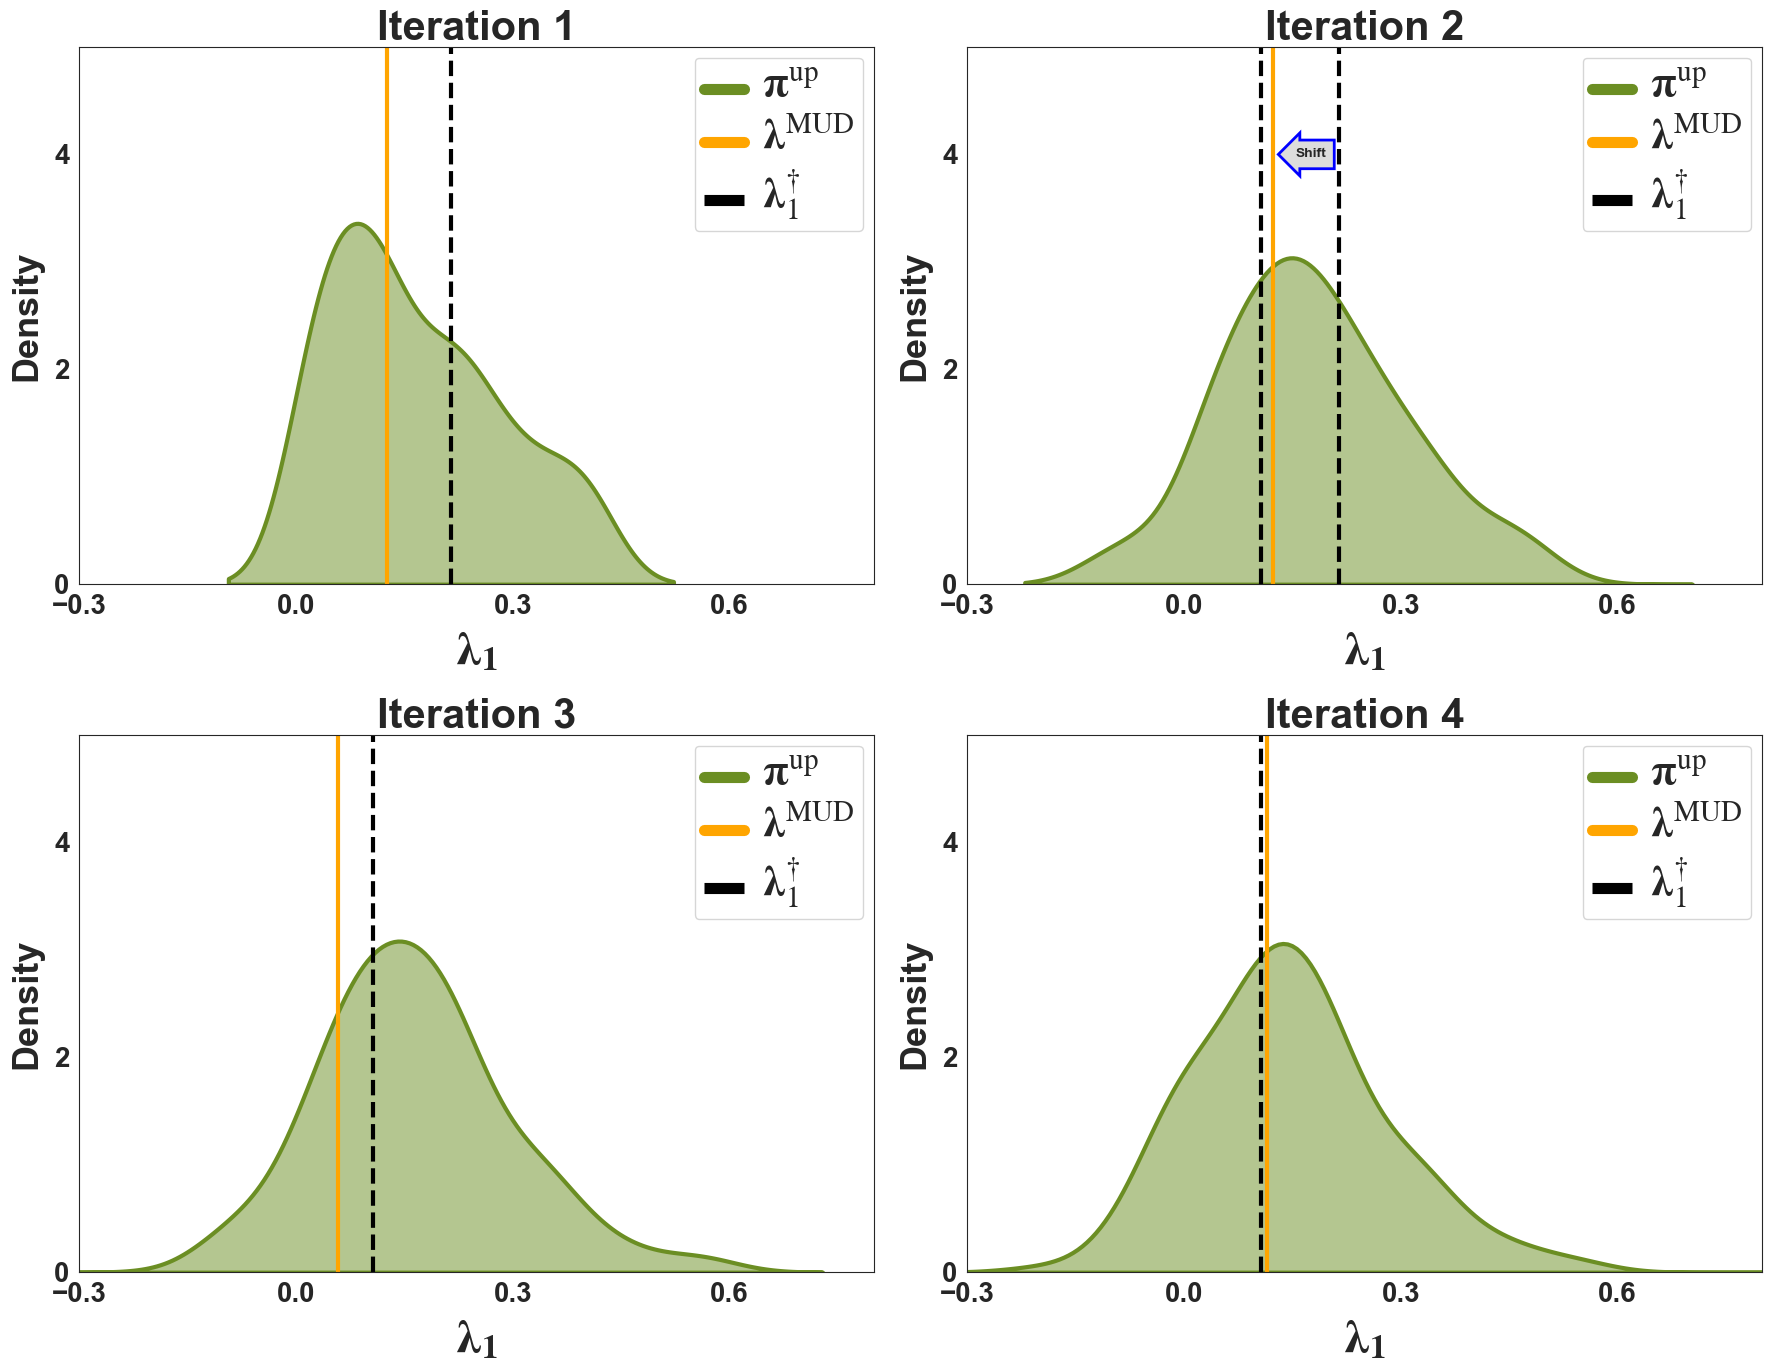

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))

sir_plot_settings1 = {
    'ax':None,
    'title':None,
    'x_lim':[-0.3, 0.8],
    'y_lim':[0.0, 5.0],
    'label_pads': [8,8],
    'label_sizes': [34,26],
    'loc': [.3,2],
    'axis_labels': [r'${\mathbf{\lambda_1}}$', 'Density'],
    'tick_label_size': 20,
    'title_pad': 5,
    'title_font_size': 30,
}

labels = [r"${\mathbf{\pi}}^{\mathrm{up}}$",
        "$\mathbf{\lambda}^{\mathrm{MUD}}$",
        "$\mathbf{\lambda}^{\dagger}_{1}$",
        ]

colors = ["olivedrab","orange","black"]
styles = ["solid","solid","dashed"]

    
plot_sir_iterations(
    prob=prob,
    param_idx=0,
    shift_arrow_idx=1,
    lam_trues=[
        [(1, SEIRS_P1)],
        [(1, SEIRS_P1), (2, SEIRS_P2)],
        [(2, SEIRS_P2)],
        [(2, SEIRS_P2)]
    ],
    idxs=[[0], [1], [2], [3]],
    axs=axs,
    iterations=[1, 2, 3, 4],
    sir_plot_settings=sir_plot_settings1,
    colors=colors,
    styles=styles,
    labels=labels
)


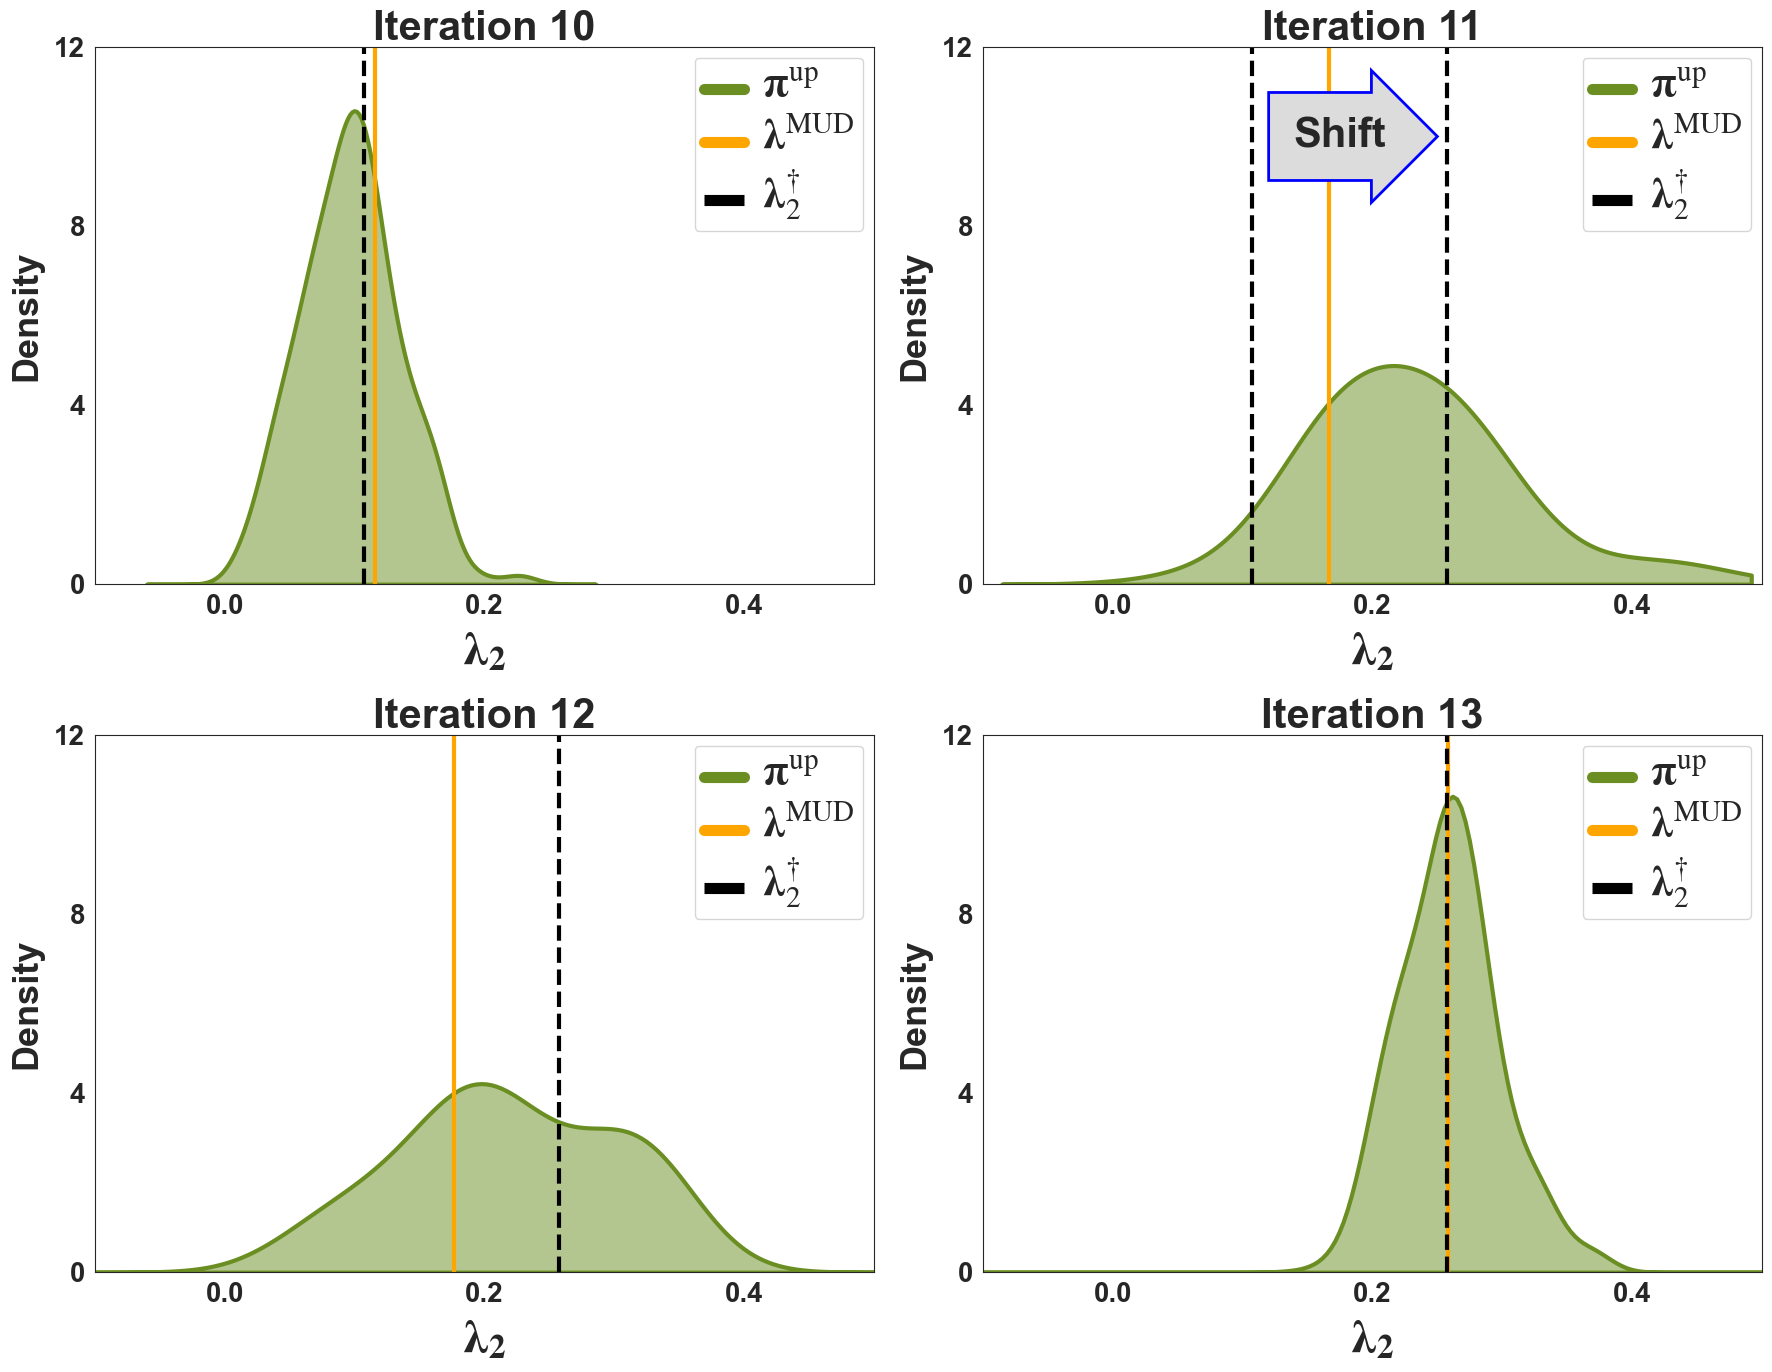

In [65]:

fig, axs = plt.subplots(2, 2, figsize=(18, 14))

sir_plot_settings2 = {
    'ax':None,
    'title':None,
    'x_lim':[-0.1, 0.5],
    'y_lim':[0.0, 12.0],
    'label_pads': [8,8],
    'label_sizes': [34,26],
    'loc': [.2,4],
    'axis_labels': [r'${\mathbf{\lambda_2}}$', 'Density'],
    'tick_label_size': 20,
    'title_pad': 5,
    'title_font_size': 30,
}

labels = [r"${\mathbf{\pi}}^{\mathrm{up}}$",
            "$\mathbf{\lambda}^{\mathrm{MUD}}$",
            "$\mathbf{\lambda}^{\dagger}_{2}$",
            ]
colors = ["olivedrab","orange","black"]
styles = ["solid","solid","dashed"]

plot_sir_iterations(
    prob=prob,
    param_idx=0,
    shift_arrow_idx=2,
    lam_trues=[
        [(1, SEIRS_P2)],
        [(1, SEIRS_P2), (2, SEIRS_P3)],
        [(2, SEIRS_P3)],
        [(2, SEIRS_P3)]
    ],
    idxs=[[10], [11], [12], [13]],
    axs=axs,
    iterations=[10,11,12,13],
    sir_plot_settings=sir_plot_settings2,
    colors=colors,
    styles=styles,
    labels=labels)

____